In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

In [2]:
paths = {'Original': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927metadata.tsv',
 'TP10K': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.TP10K.h5ad'}

# Run cNMF

In [3]:
cnmfdir = '../../../Data/PerDataset/XTissueImmuneAtlas'
name = 'XTissue.20230927.NoBlood'

In [338]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(15, 60)
n_iter = 20
num_per_node = 10

In [4]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [7]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [8]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

90

In [60]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(1, total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J XTissue.20230927.NoBlood -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log/XTissue.20230927.NoBlood.1.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log/XTissue.20230927.NoBlood.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name XTissue.20230927.NoBlood --output-dir ../../../Data/PerDataset/XTissueImmuneAtlas --total-workers 90 --worker-index 1"
Job <875003> is submitted to queue <short>.
bsub -q short -J XTissue.20230927.NoBlood -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log/XTissue.20230927.NoBlood.2.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log/XTissue.20230927.NoBlood.2.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "sele

In [112]:
! bjobs

JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
875007  dk718   RUN   short      cn071       cmu073      *7.NoBlood Sep 27 18:19
875070  dk718   RUN   short      cn071       cmu065      *7.NoBlood Sep 27 18:19
875008  dk718   RUN   short      cn071       cmu089      *7.NoBlood Sep 27 18:19
875039  dk718   RUN   short      cn071       cmu081      *7.NoBlood Sep 27 18:19
875009  dk718   RUN   short      cn071       cmu118      *7.NoBlood Sep 27 18:19
875010  dk718   RUN   short      cn071       cmu102      *7.NoBlood Sep 27 18:19
875011  dk718   RUN   short      cn071       cmu106      *7.NoBlood Sep 27 18:19
875018  dk718   RUN   short      cn071       cn078       *7.NoBlood Sep 27 18:19
875049  dk718   RUN   short      cn071       cn078       *7.NoBlood Sep 27 18:19
875080  dk718   RUN   short      cn071       cn078       *7.NoBlood Sep 27 18:19
875024  dk718   RUN   short      cn071       cn054       *7.NoBlood Sep 27 18:19
875054  dk718   RUN   short  

In [120]:
! bjobs | wc -l

No unfinished job found
0


In [138]:
! ls ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/cnmf_tmp | grep "spectra" | wc -l

767


In [133]:
len(Ks)

45

In [122]:
90*20

1800

In [123]:
! ls ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log

XTissue.20230927.NoBlood.0.err.txt   XTissue.20230927.NoBlood.50.err.txt
XTissue.20230927.NoBlood.0.out.txt   XTissue.20230927.NoBlood.50.out.txt
XTissue.20230927.NoBlood.10.err.txt  XTissue.20230927.NoBlood.51.err.txt
XTissue.20230927.NoBlood.10.out.txt  XTissue.20230927.NoBlood.51.out.txt
XTissue.20230927.NoBlood.11.err.txt  XTissue.20230927.NoBlood.52.err.txt
XTissue.20230927.NoBlood.11.out.txt  XTissue.20230927.NoBlood.52.out.txt
XTissue.20230927.NoBlood.12.err.txt  XTissue.20230927.NoBlood.53.err.txt
XTissue.20230927.NoBlood.12.out.txt  XTissue.20230927.NoBlood.53.out.txt
XTissue.20230927.NoBlood.13.err.txt  XTissue.20230927.NoBlood.54.err.txt
XTissue.20230927.NoBlood.13.out.txt  XTissue.20230927.NoBlood.54.out.txt
XTissue.20230927.NoBlood.14.err.txt  XTissue.20230927.NoBlood.55.err.txt
XTissue.20230927.NoBlood.14.out.txt  XTissue.20230927.NoBlood.55.out.txt
XTissue.20230927.NoBlood.15.err.txt  XTissue.20230927.NoBlood.56.err.txt
XTissue.20230927.NoBlood.15.out.txt  XTissue.202309

In [124]:
total_workers = int((len(Ks)*n_iter))
total_workers

900

In [150]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

In [151]:
len(missing)

0

In [147]:
! bjobs | wc -l

3


In [130]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J XTissue.20230927.NoBlood -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log/XTissue.20230927.NoBlood.348.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log/XTissue.20230927.NoBlood.348.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name XTissue.20230927.NoBlood --output-dir ../../../Data/PerDataset/XTissueImmuneAtlas --total-workers 900 --worker-index 348"
Job <875105> is submitted to queue <short>.
bsub -q short -J XTissue.20230927.NoBlood -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log/XTissue.20230927.NoBlood.438.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/log/XTissue.20230927.NoBlood.438.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002

In [148]:
! bjobs

JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
875194  dk718   RUN   short      cn071       cn078       *7.NoBlood Sep 27 21:08
875222  dk718   RUN   short      cn071       cn078       *7.NoBlood Sep 27 21:08


In [152]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizations for k=38.
Combining factorizations for k=39.
Combining factorizations for k=40.
Combining factorizations for k=41.
Combining factorizations for k=42.
Combining factorizat

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 1h 15min 54s, sys: 1h 6min 11s, total: 2h 22min 6s
Wall time: 10min 37s


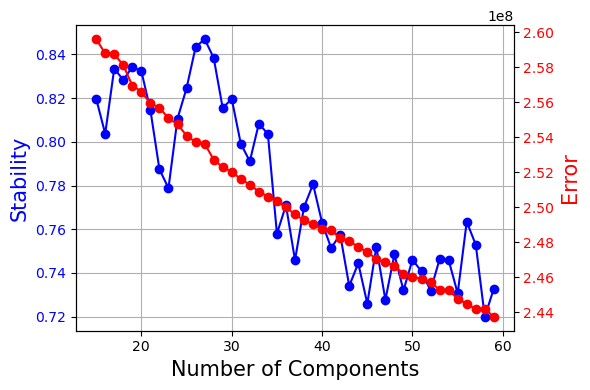

In [153]:
%%time
cnmf_obj.k_selection_plot()

In [5]:
figdir = '../../../Figures/Components'

In [6]:
cmd = 'cp {} {}'.format(cnmf_obj.paths['k_selection_plot'], 
                           os.path.join(figdir, '%s.k_selection.png' % name))

print(cmd)

cp ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/XTissue.20230927.NoBlood.k_selection.png ../../../Figures/Components/XTissue.20230927.NoBlood.k_selection.png


In [7]:
print(cmd)
! {cmd}

cp ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood/XTissue.20230927.NoBlood.k_selection.png ../../../Figures/Components/XTissue.20230927.NoBlood.k_selection.png


In [322]:
kthresh = {28:0.2, 30:0.2, 33:.2, 34:.2, 39:.2, 40:.2, 56:.2}


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


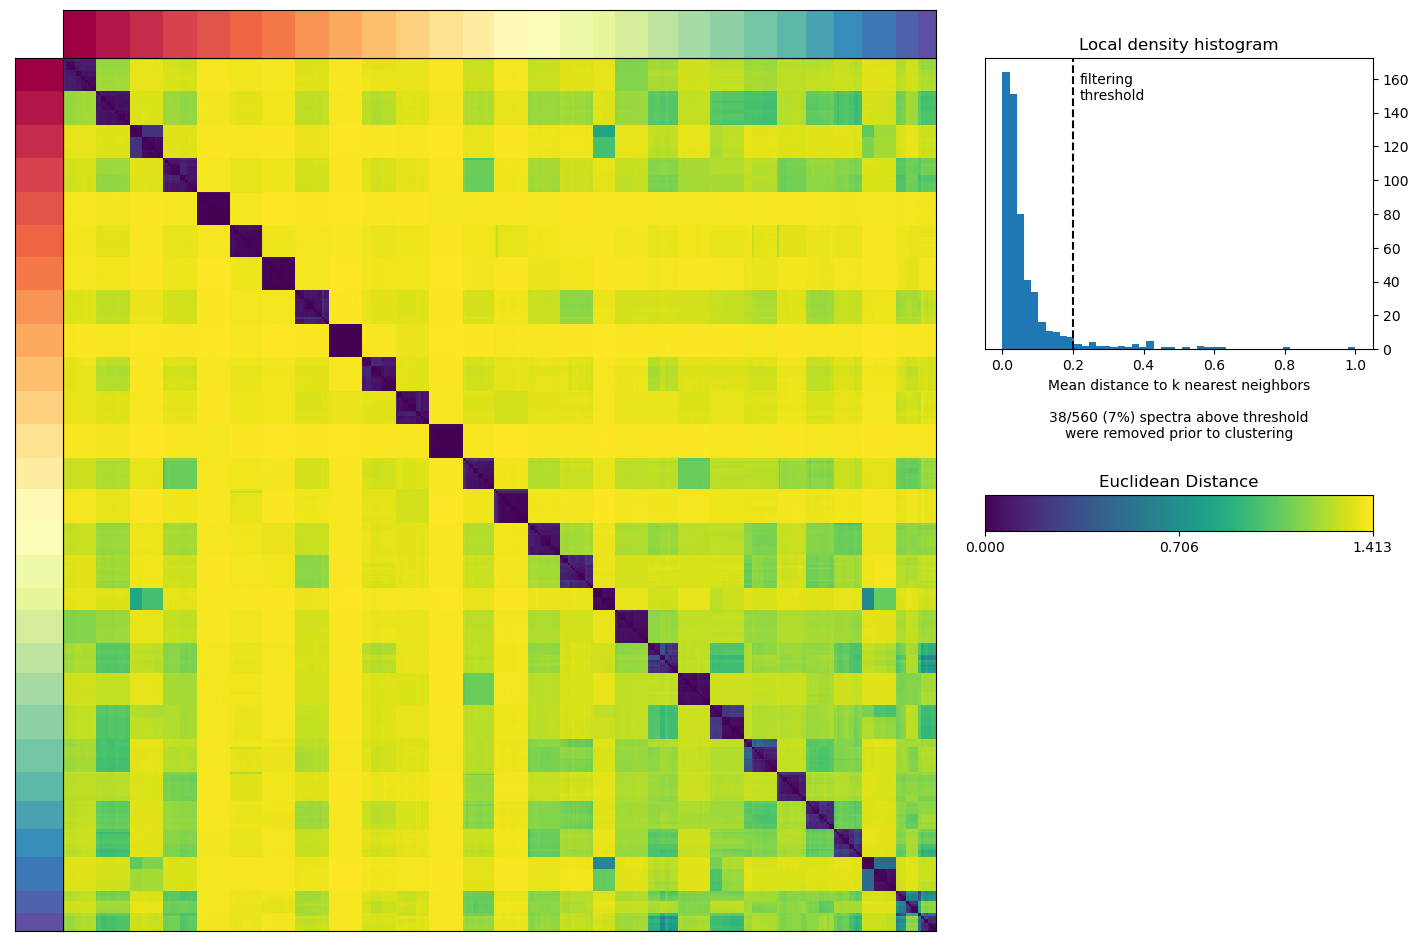

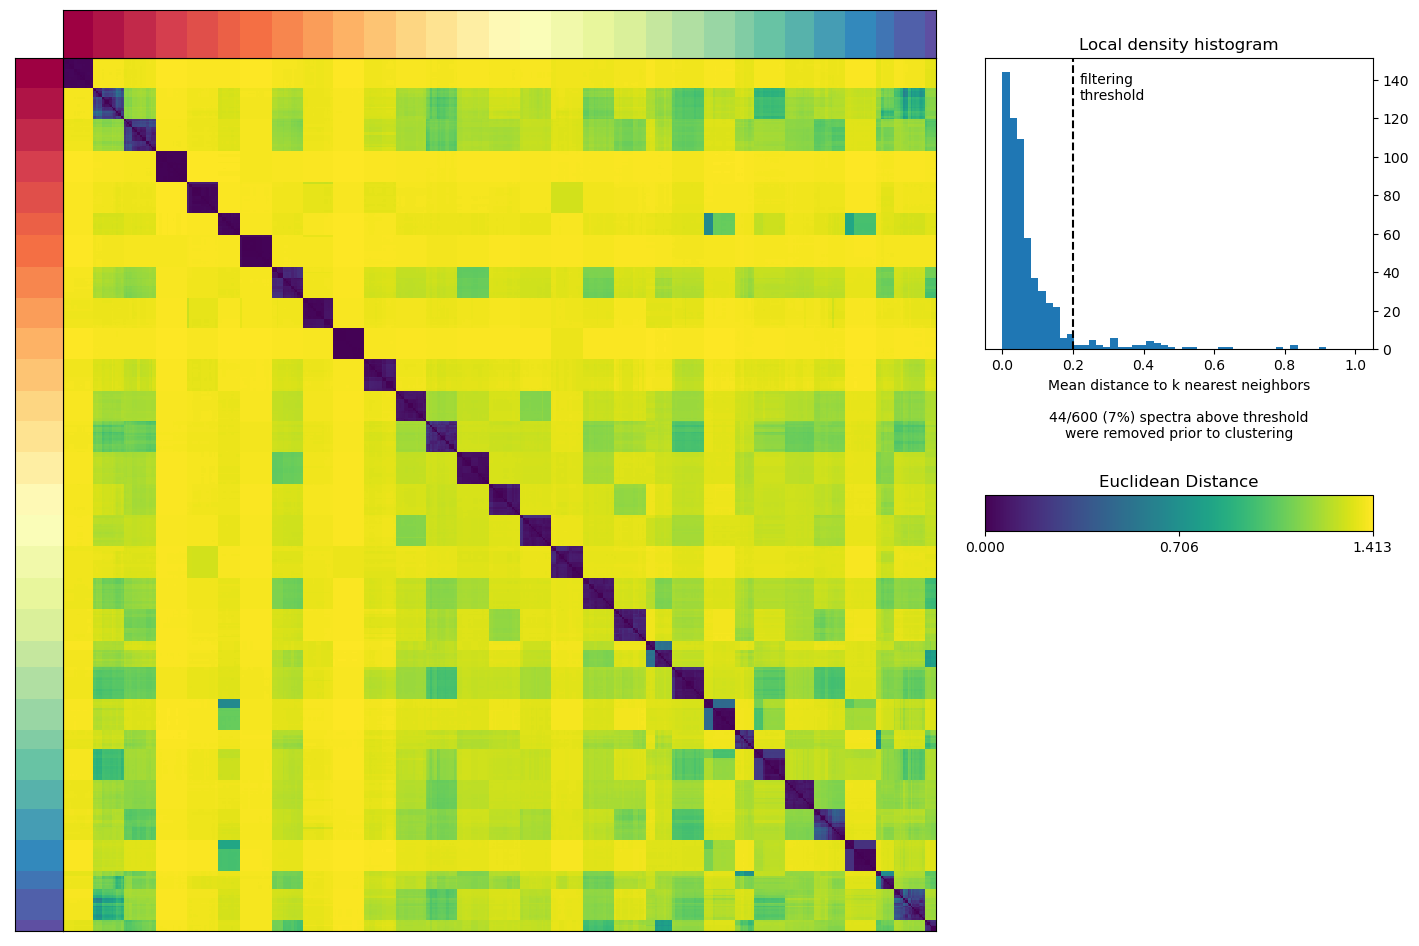

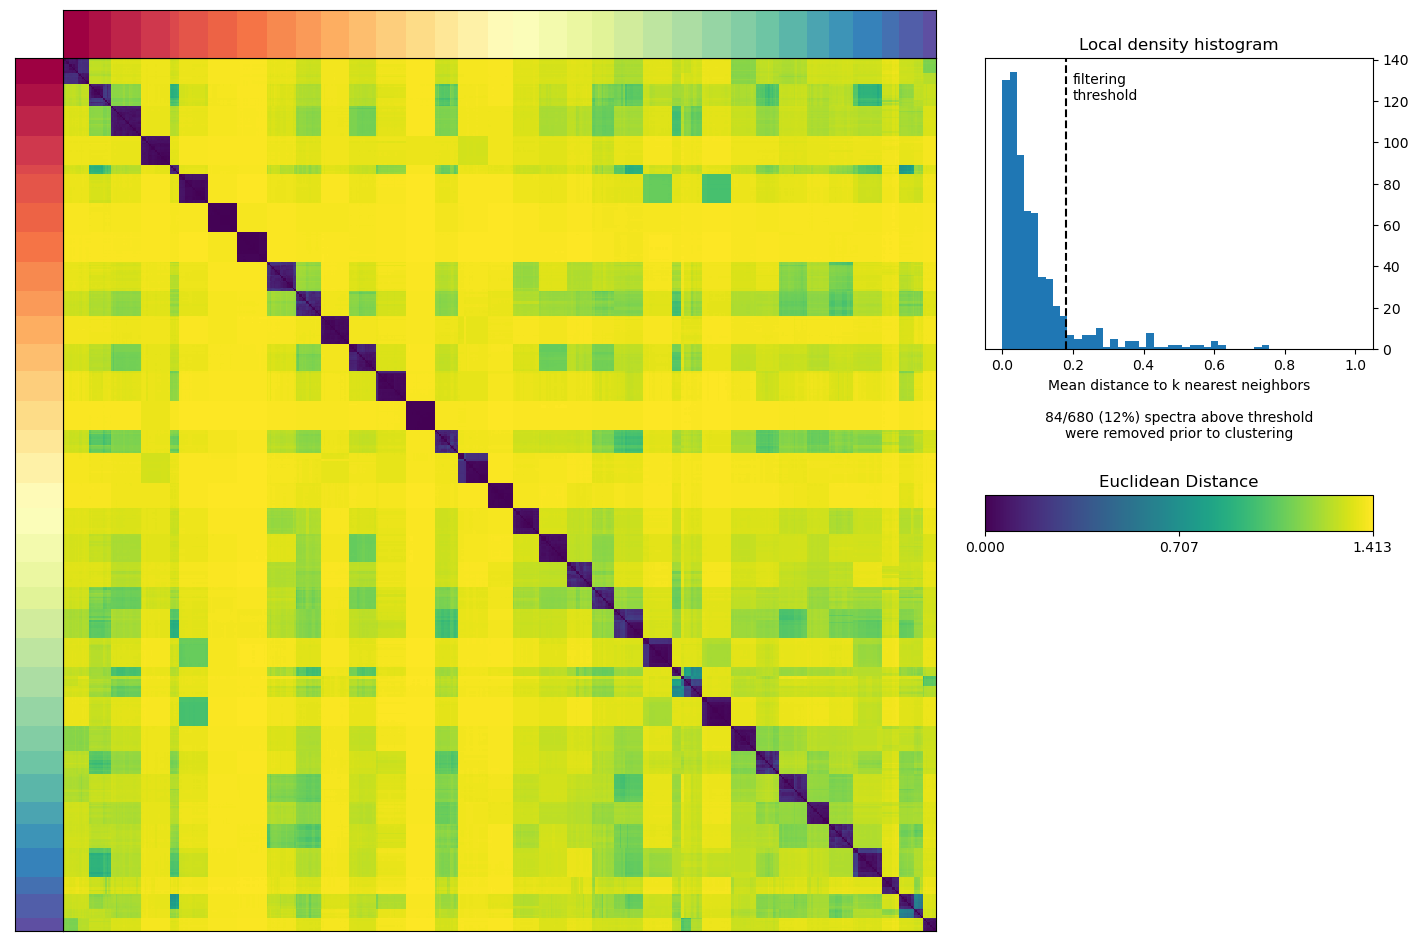

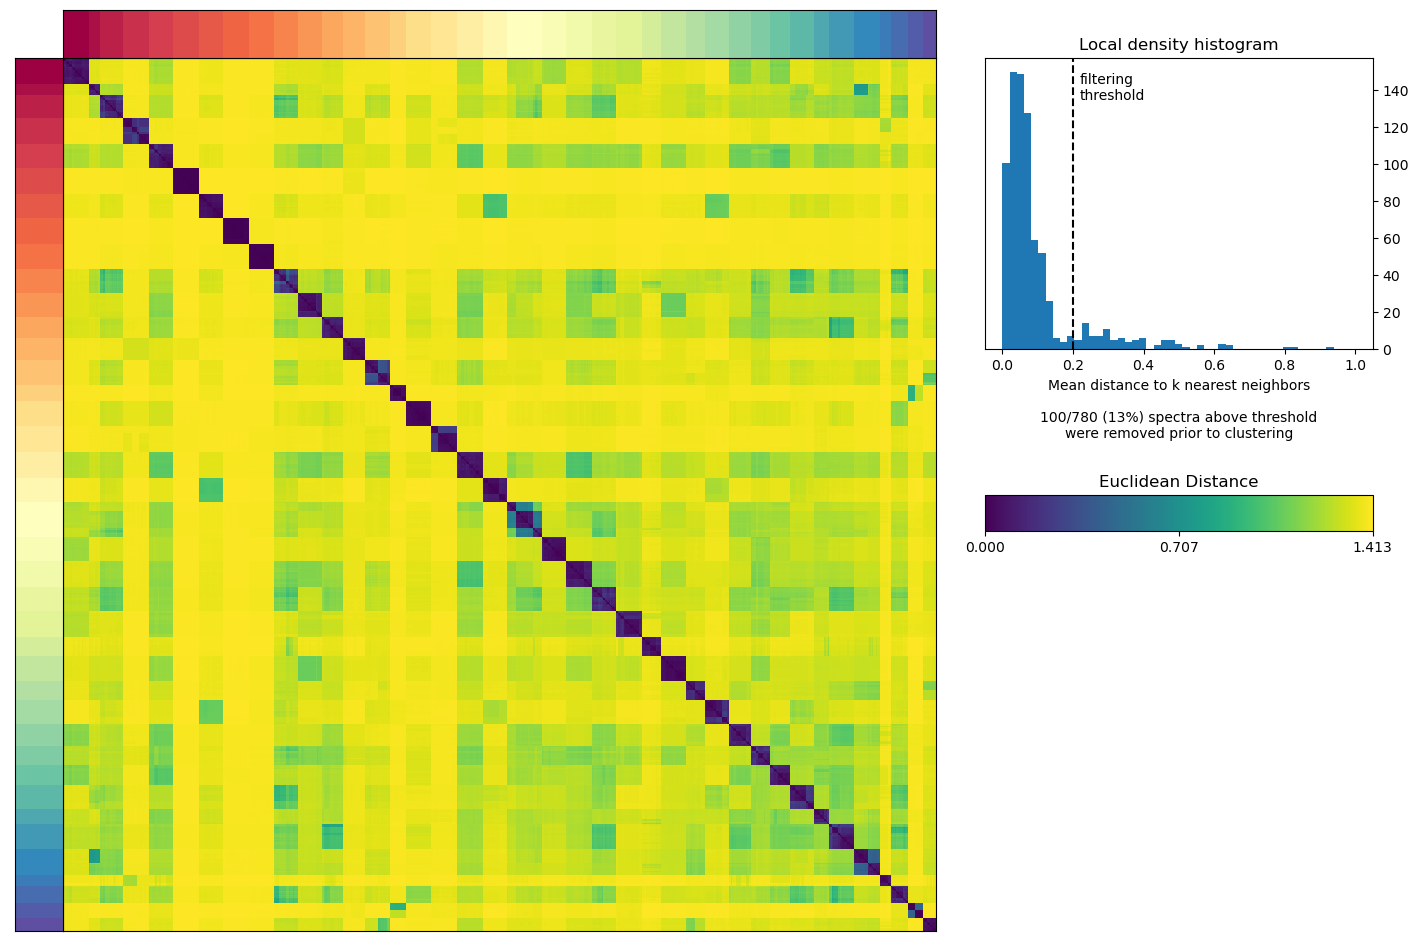

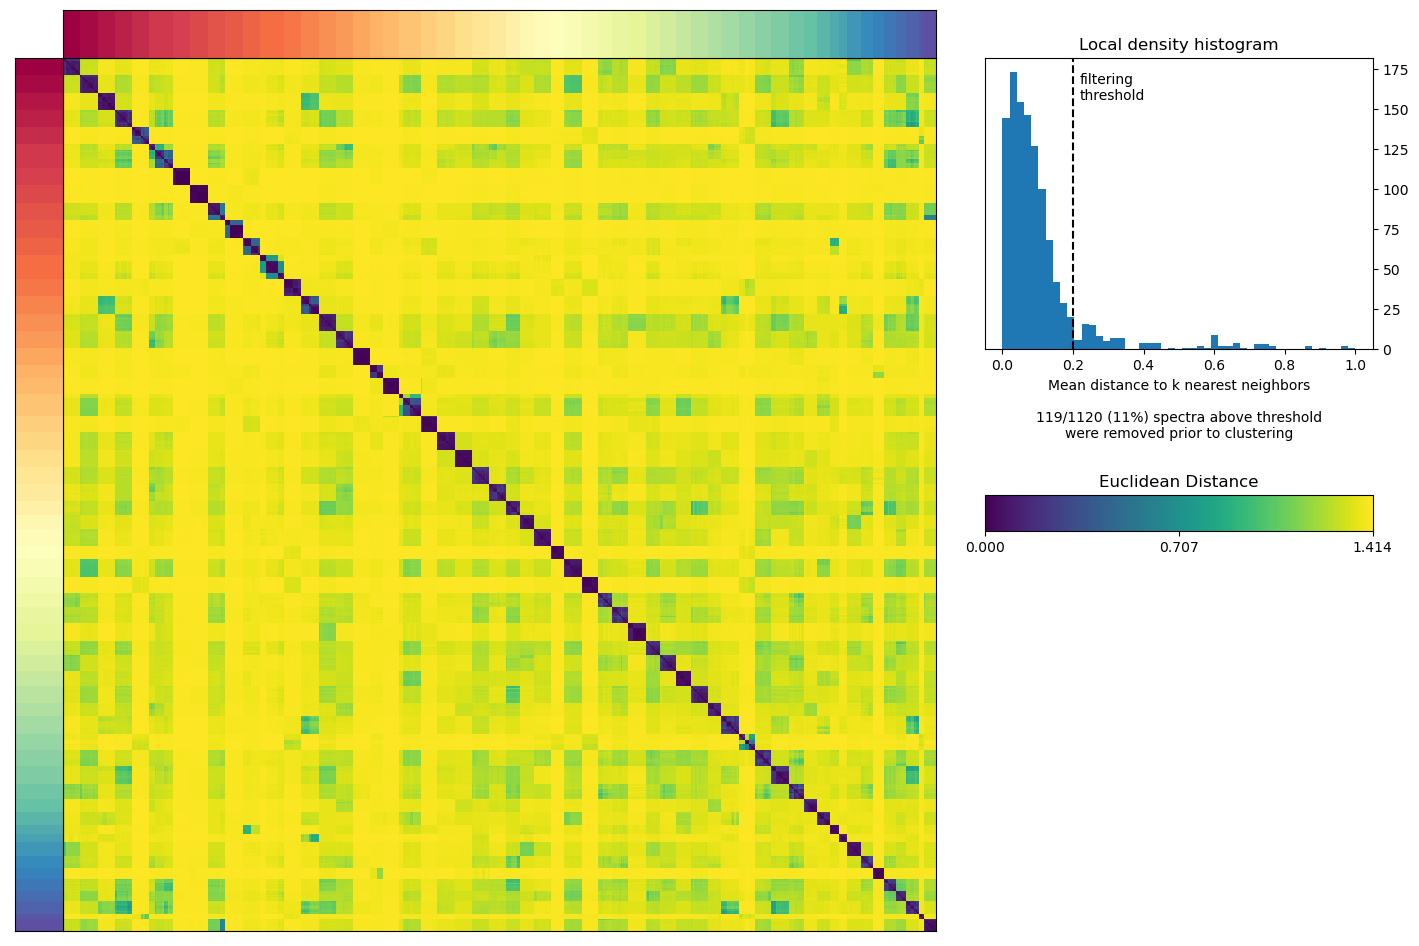

In [155]:
for k in [28, 30, 34, 39, 56]:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


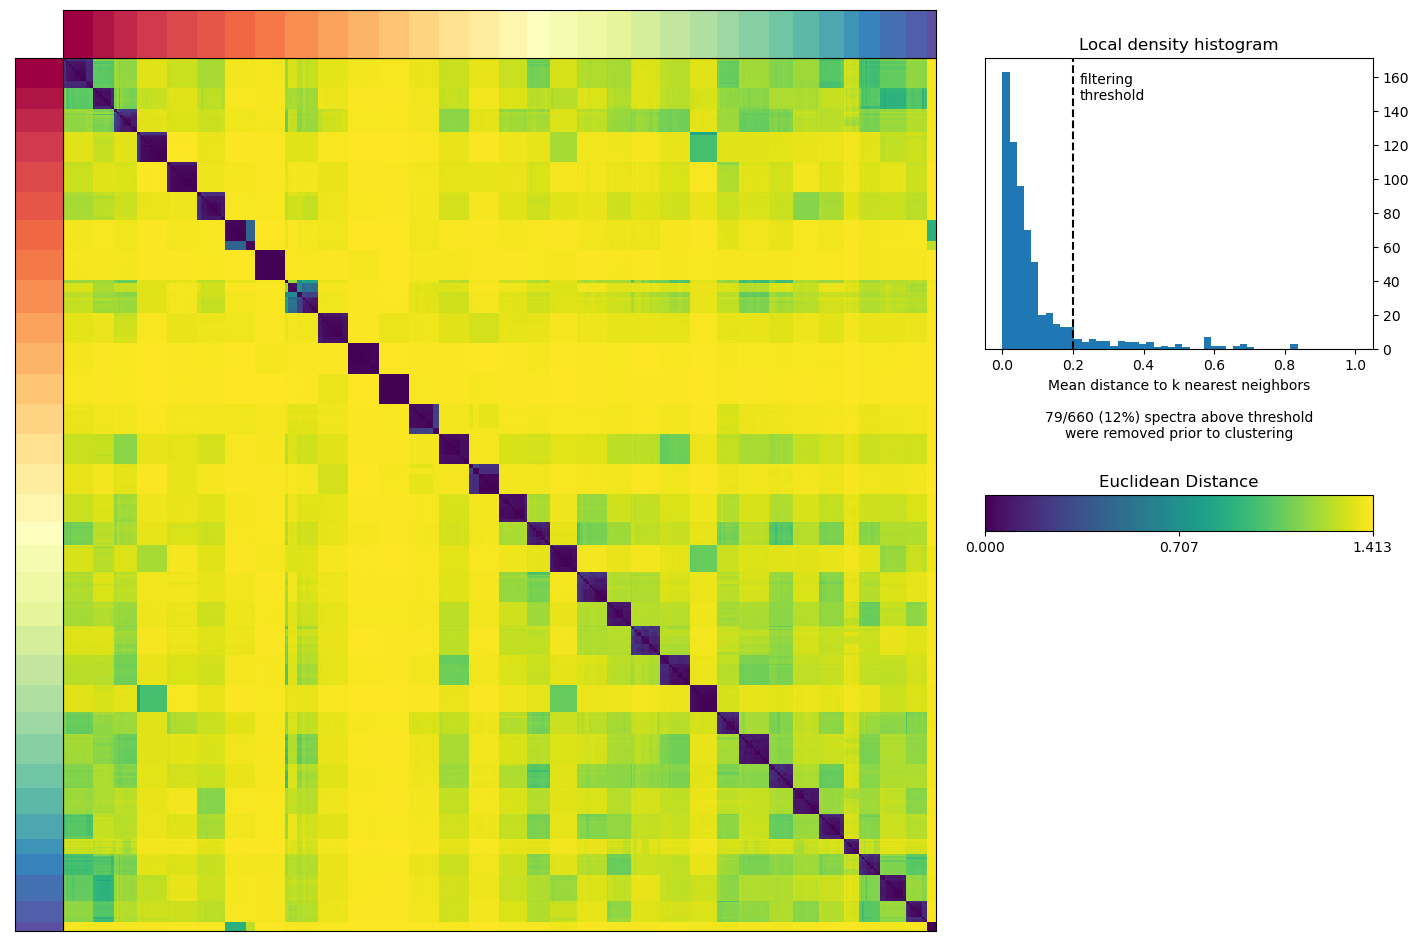

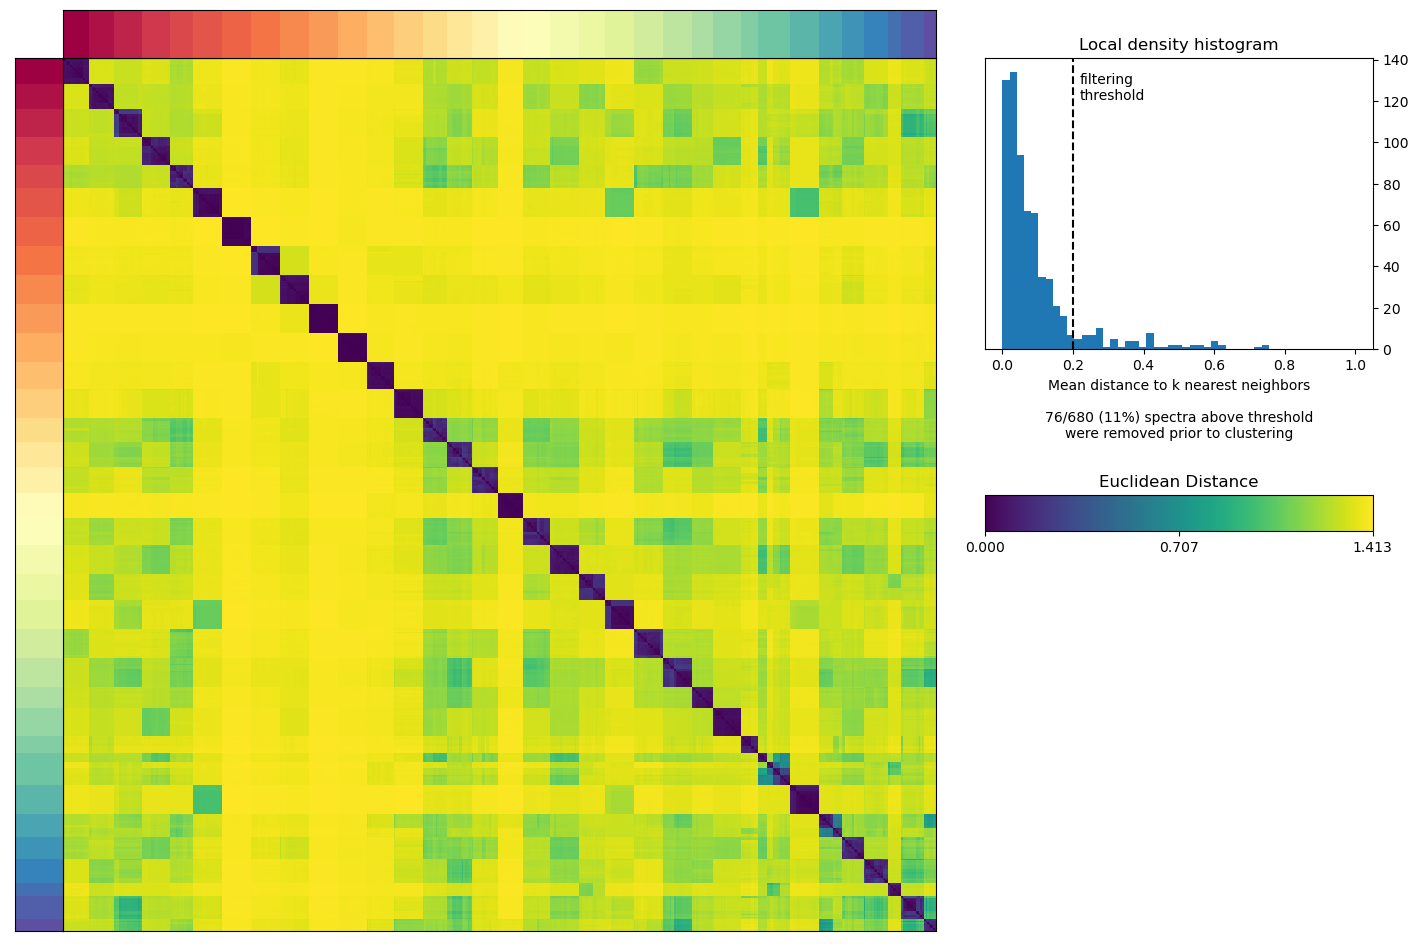

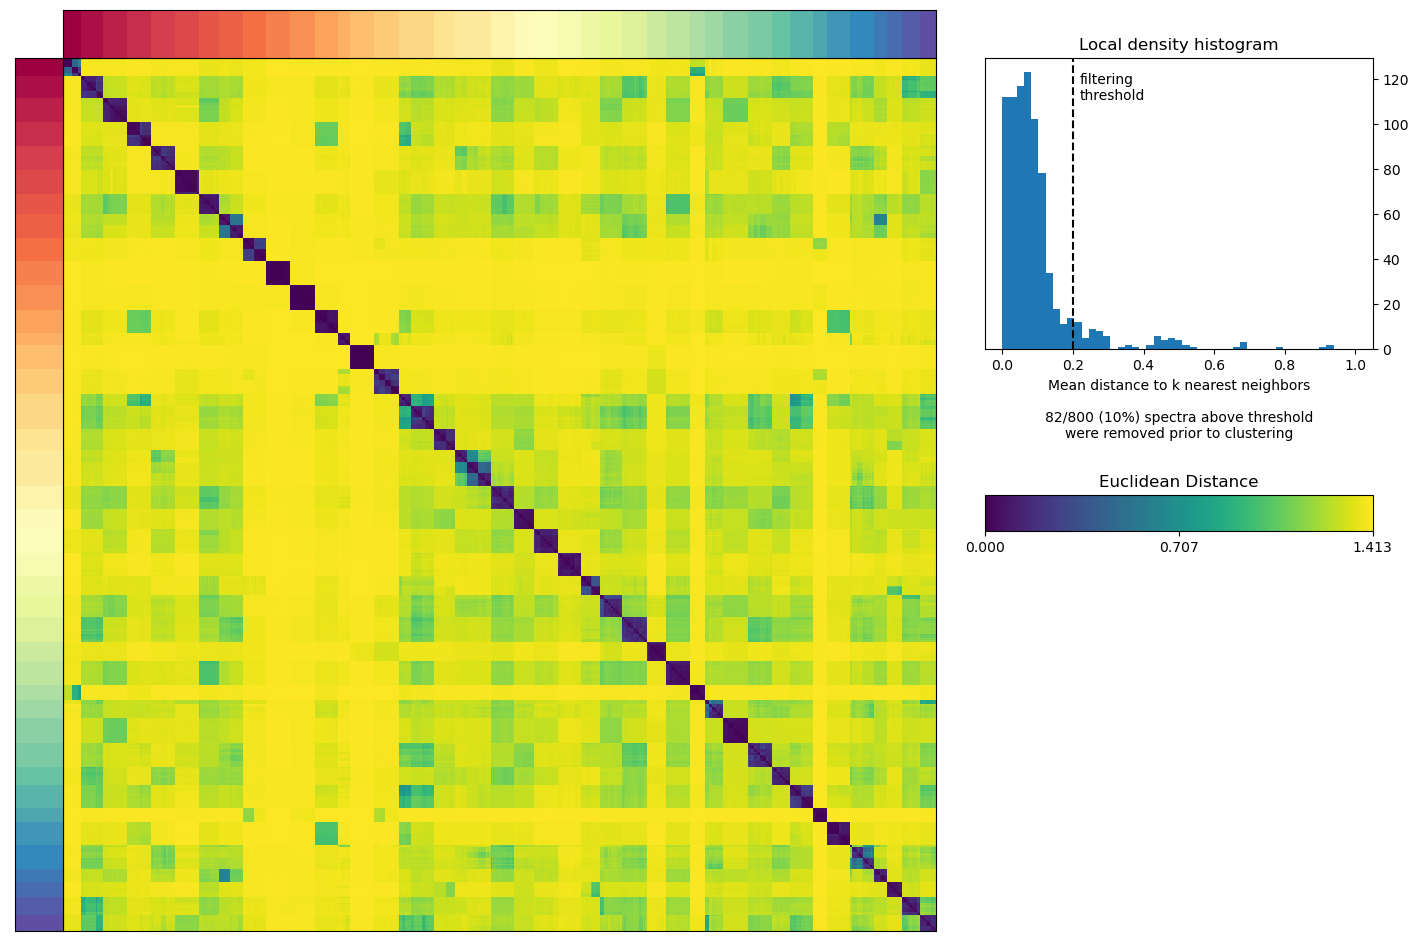

In [196]:
for k in [33, 34, 40]:
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

In [323]:
kthresh

{28: 0.2, 30: 0.2, 33: 0.2, 34: 0.2, 39: 0.2, 40: 0.2, 56: 0.2}

## Compare with original TCATs

In [333]:
metagepinfo = read_dataset_log(tabname='Current Meta-program Paths').loc[0,:]
metagepinfo

clustering_fn                      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                        /data/srlab1/TCAT/Data/TCAT/MergedHVG.UnionAll...
tpm_norm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_norm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                     /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
Name: 0, dtype: object

In [334]:
clustering = pd.read_csv(metagepinfo.loc['clustering_with_singletons_fn'], sep='\t', index_col=0)
clustering.head()

AMP-RA  \
CellCycle-G2M_CellCycle_G2M                  AMP-RA:CellCycle-G2M   
ISG                                                    AMP-RA:ISG   
gdT                                                           NaN   
Metallothionein                            AMP-RA:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  AMP-RA:CellCycle-Sphase   

                                                          UK-Covid  \
CellCycle-G2M_CellCycle_G2M                 UK-Covid:CellCycle_G2M   
ISG                                                   UK-Covid:ISG   
gdT                                                   UK-Covid:gdT   
Metallothionein                           UK-Covid:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      UK-Covid:CellCycle_S   

                                                           Pan-Tissue  \
CellCycle-G2M_CellCycle_G2M                  Pan-Tissue:CellCycle-G2M   
ISG                                                    Pan-Tissue:ISG   
gdT                                                               NaN   
Metallothionein                            Pan-Tissue:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Tissue:CellCycle-Sphase   

                                                        HIV-Vaccine  \
CellCycle-G2M_CellCycle_G2M               HIV-Vaccine:CellCycle_G2M   
ISG                                                 HIV-Vaccine:ISG   
gdT                                                 HIV-Vaccine:gdT   
Metallothionein                                                 NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    HIV-Vaccine:CellCycle_S   

                                                          COMBAT  \
CellCycle-G2M_CellCycle_G2M                 COMBAT:CellCycle_G2M   
ISG                                                   COMBAT:ISG   
gdT                                                   COMBAT:gdT   
Metallothionein                           COMBAT:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      COMBAT:CellCycle_S   

                                                        TBRU  \
CellCycle-G2M_CellCycle_G2M               TBRU:CellCycle_G2M   
ISG                                                 TBRU:ISG   
gdT                                                 TBRU:gdT   
Metallothionein                                          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    TBRU:DTL/FAM111B   

                                                           Pan-Cancer  
CellCycle-G2M_CellCycle_G2M                  Pan-Cancer:CellCycle-G2M  
ISG                                                    Pan-Cancer:ISG  
gdT                                                               NaN  
Metallothionein                            Pan-Cancer:Metallothionein  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Cancer:CellCycle-Sphase

In [335]:
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T

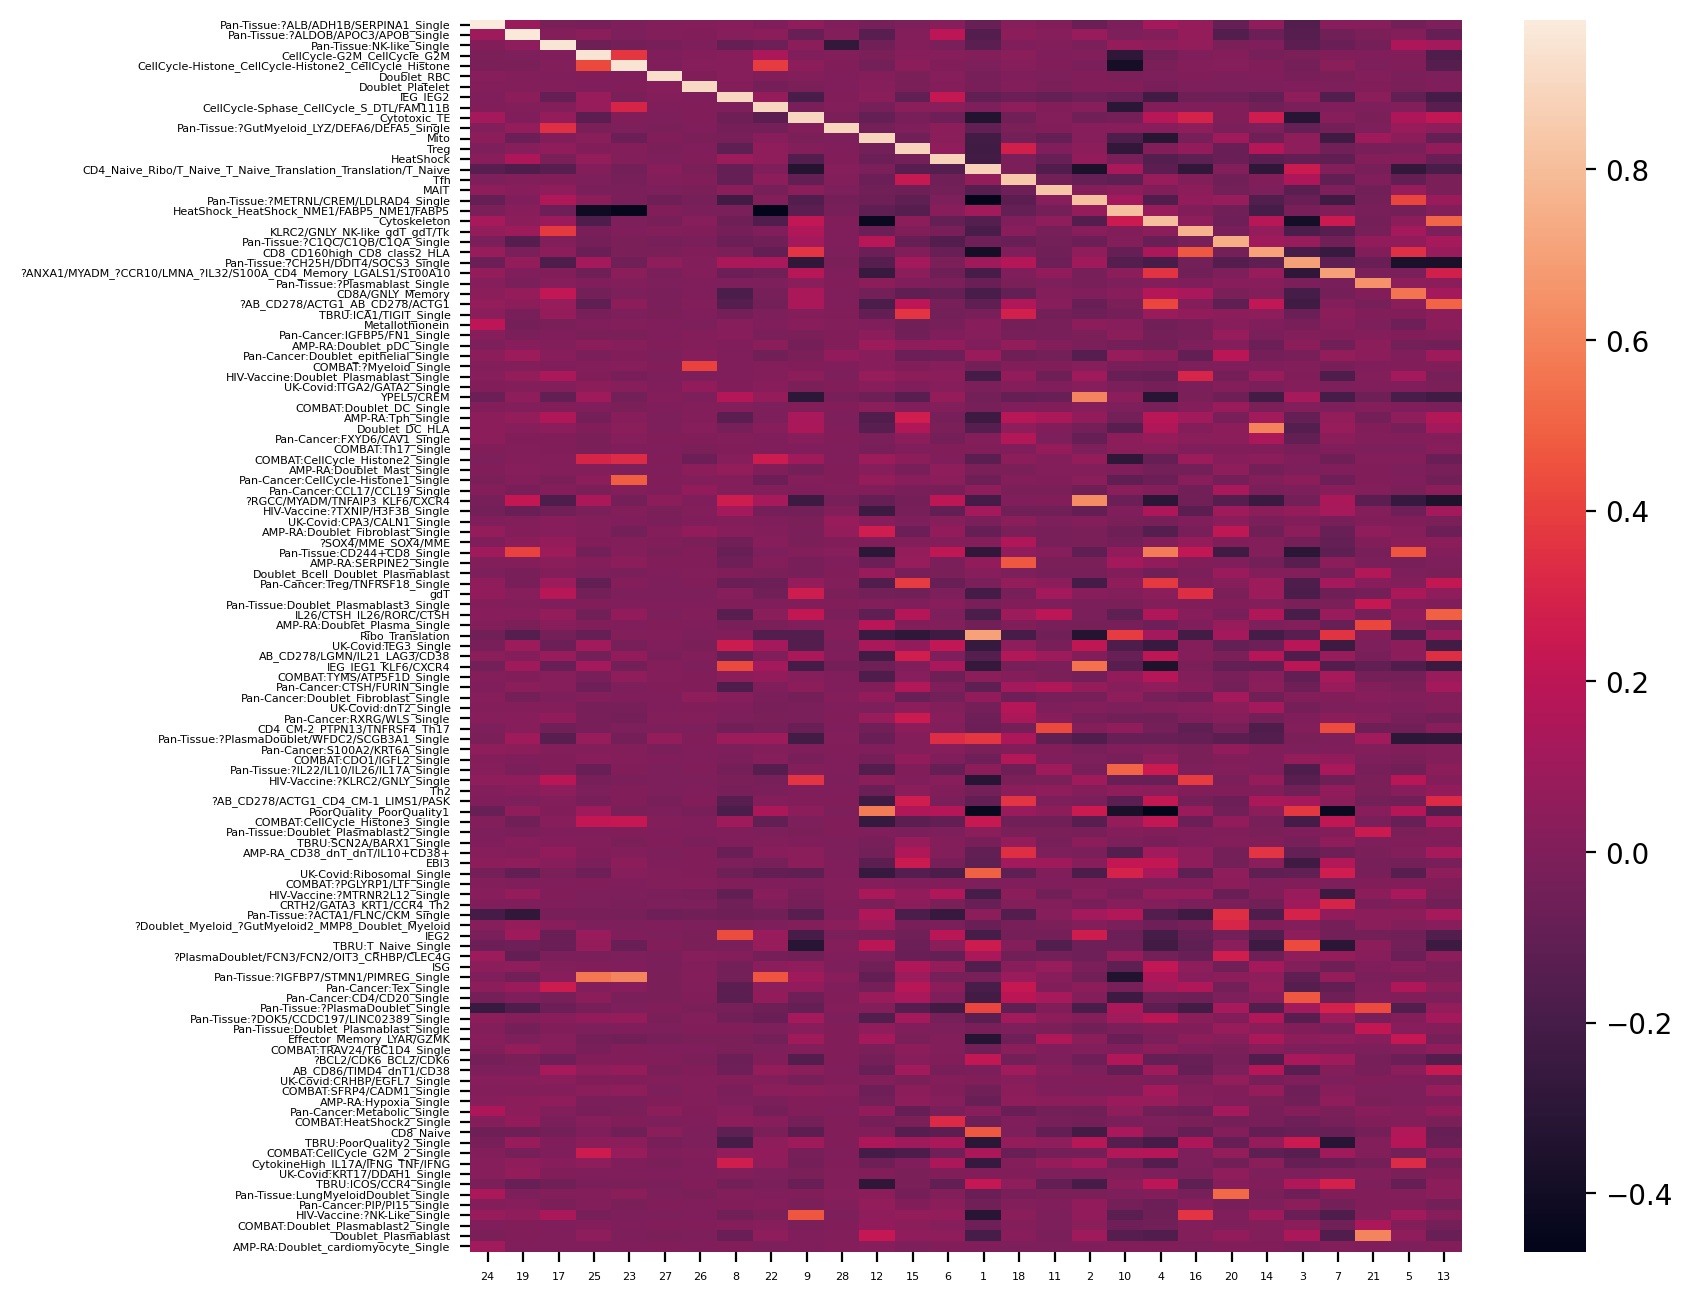

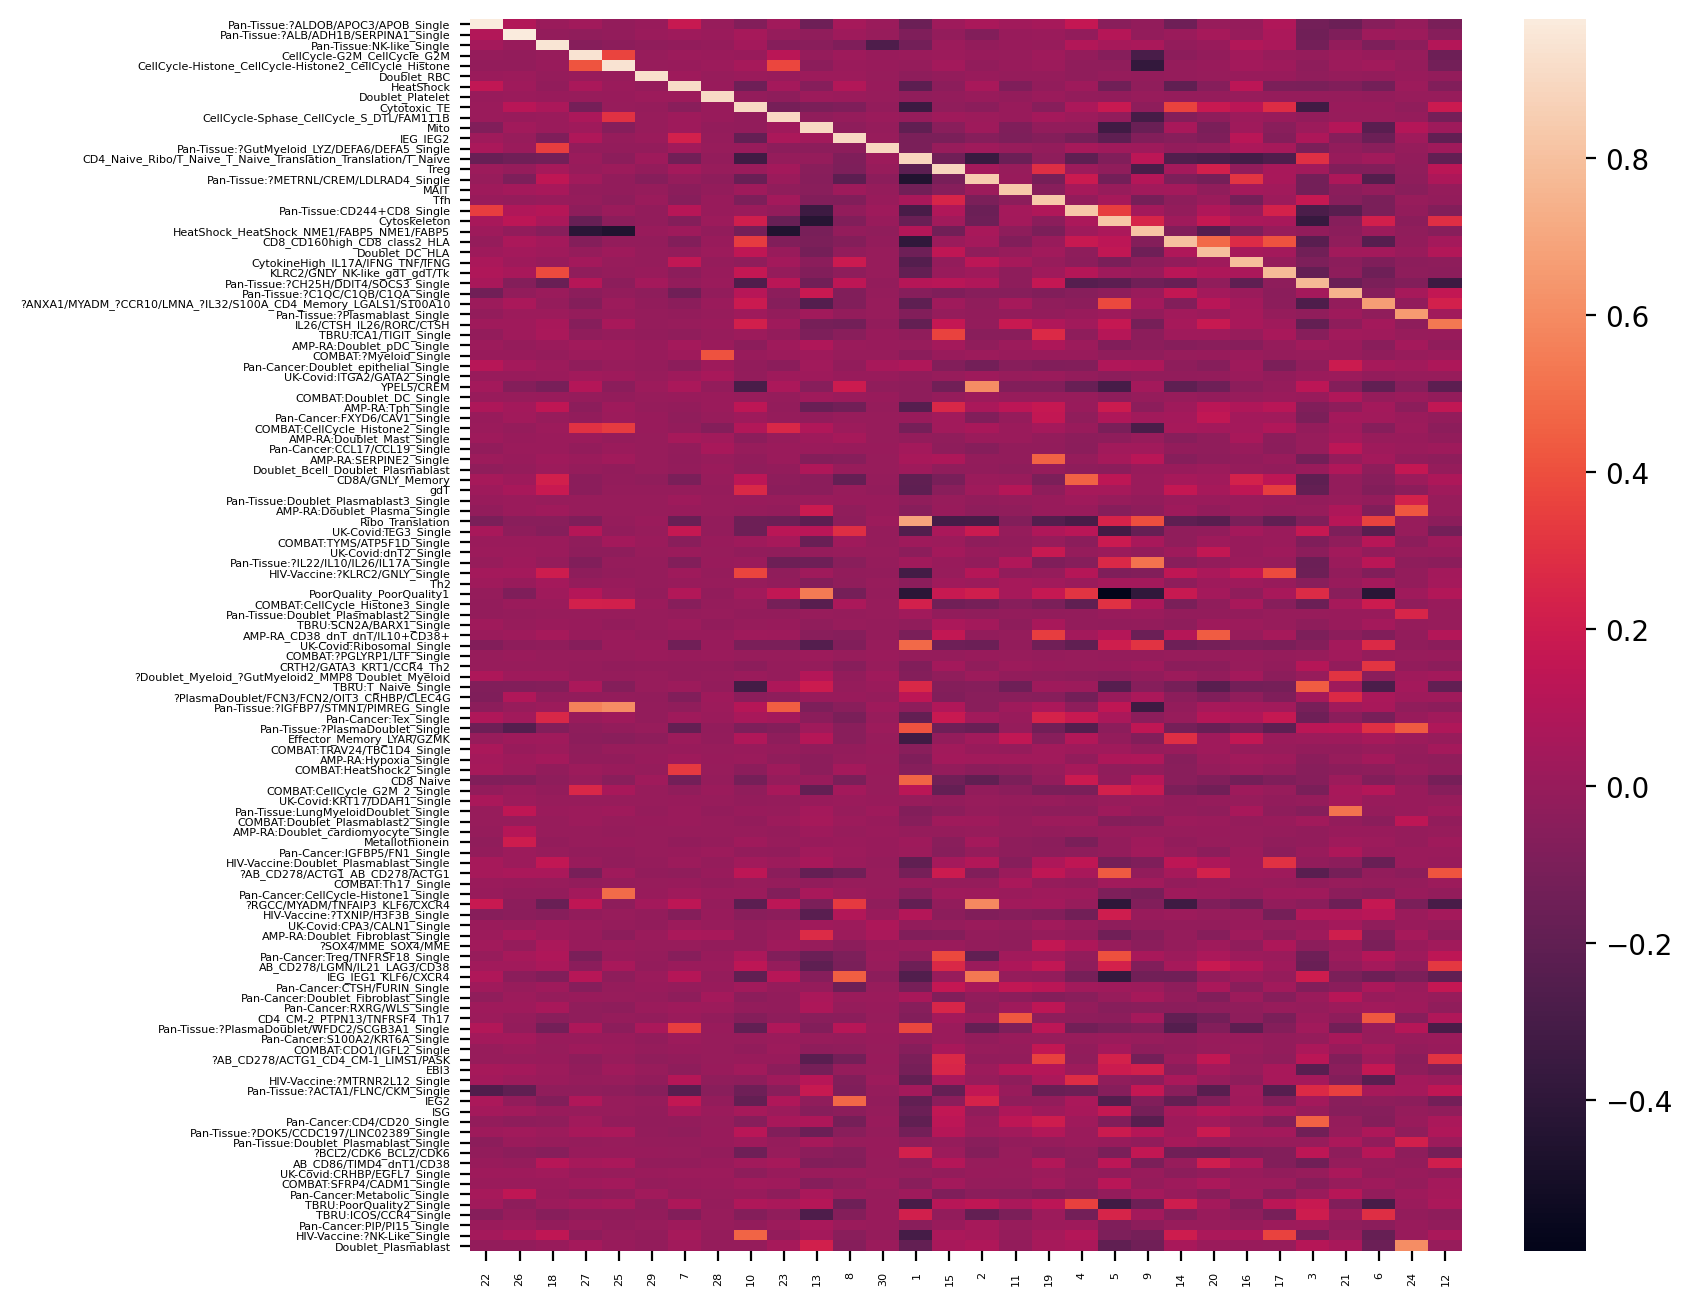

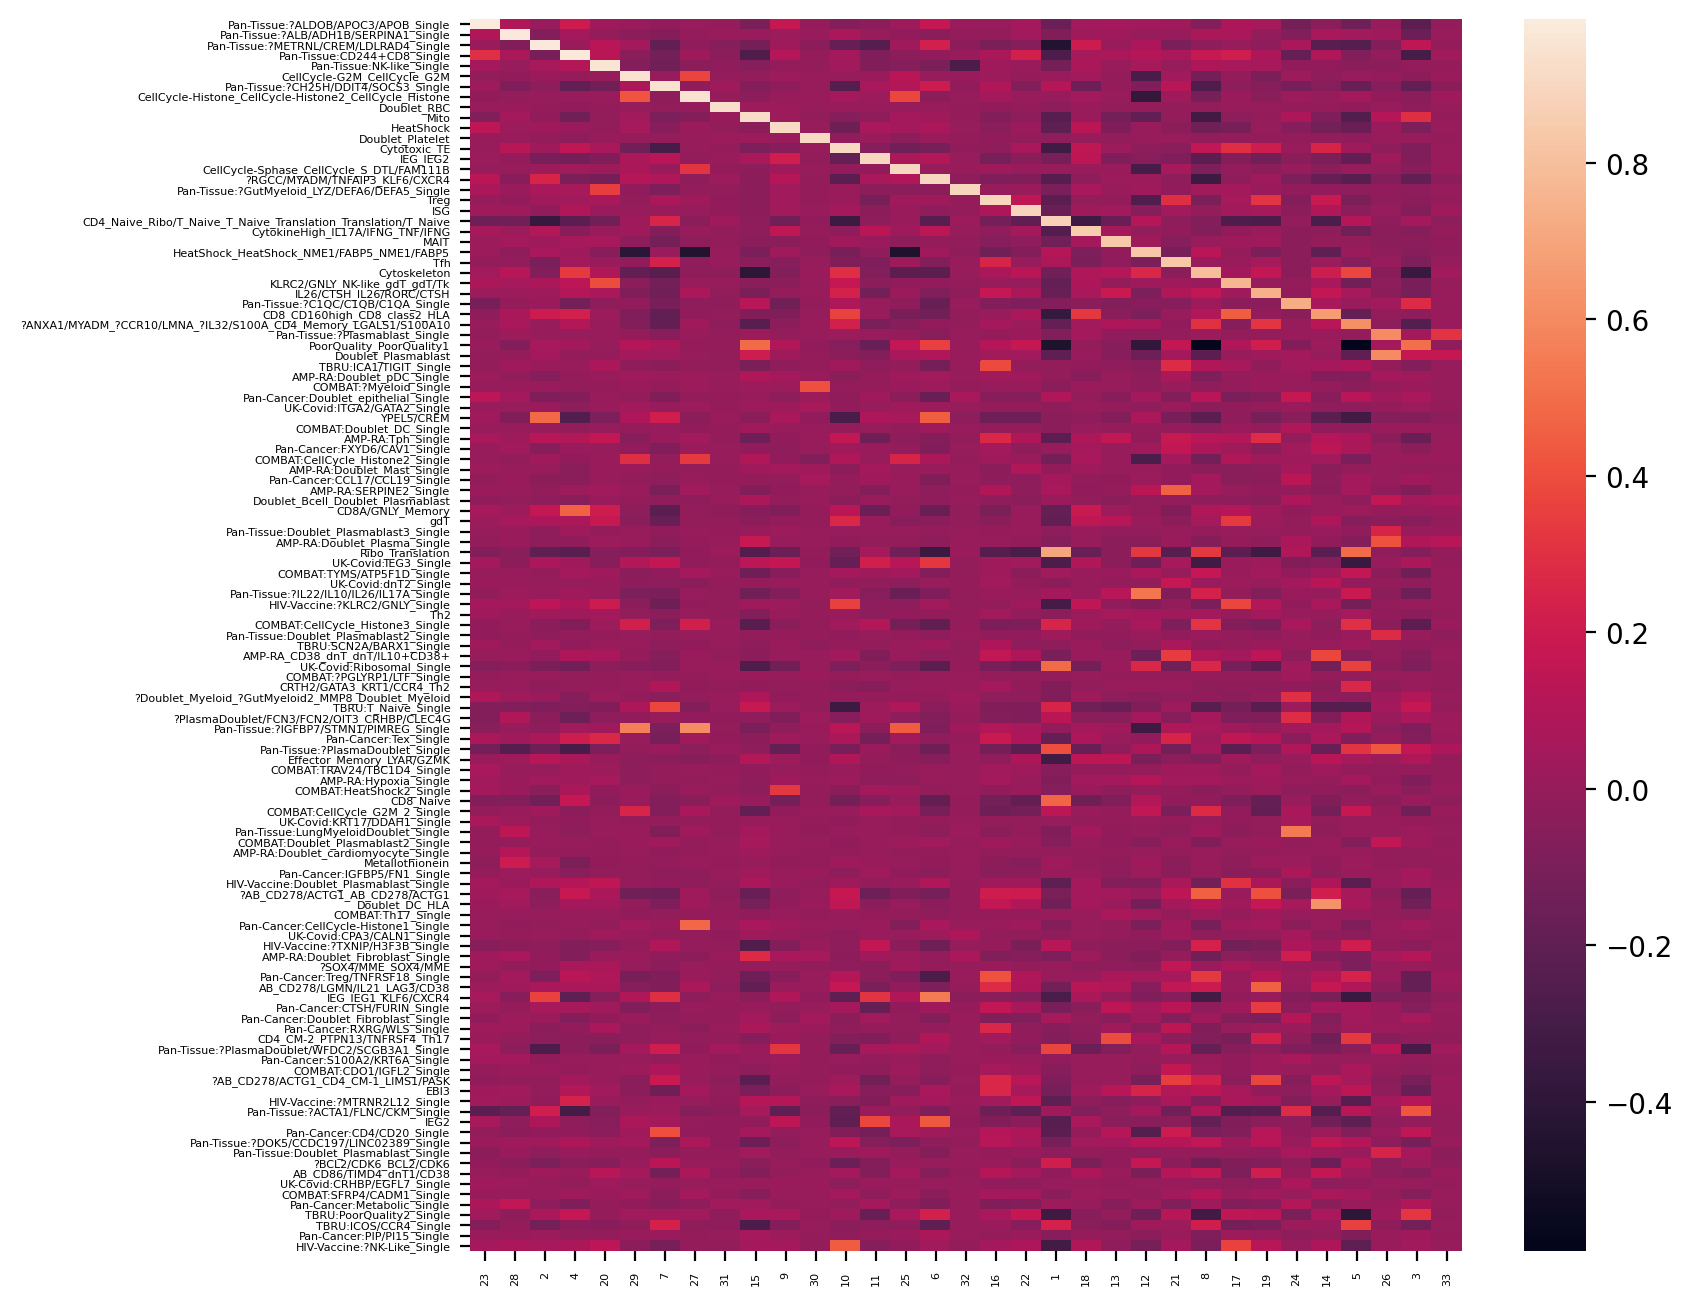

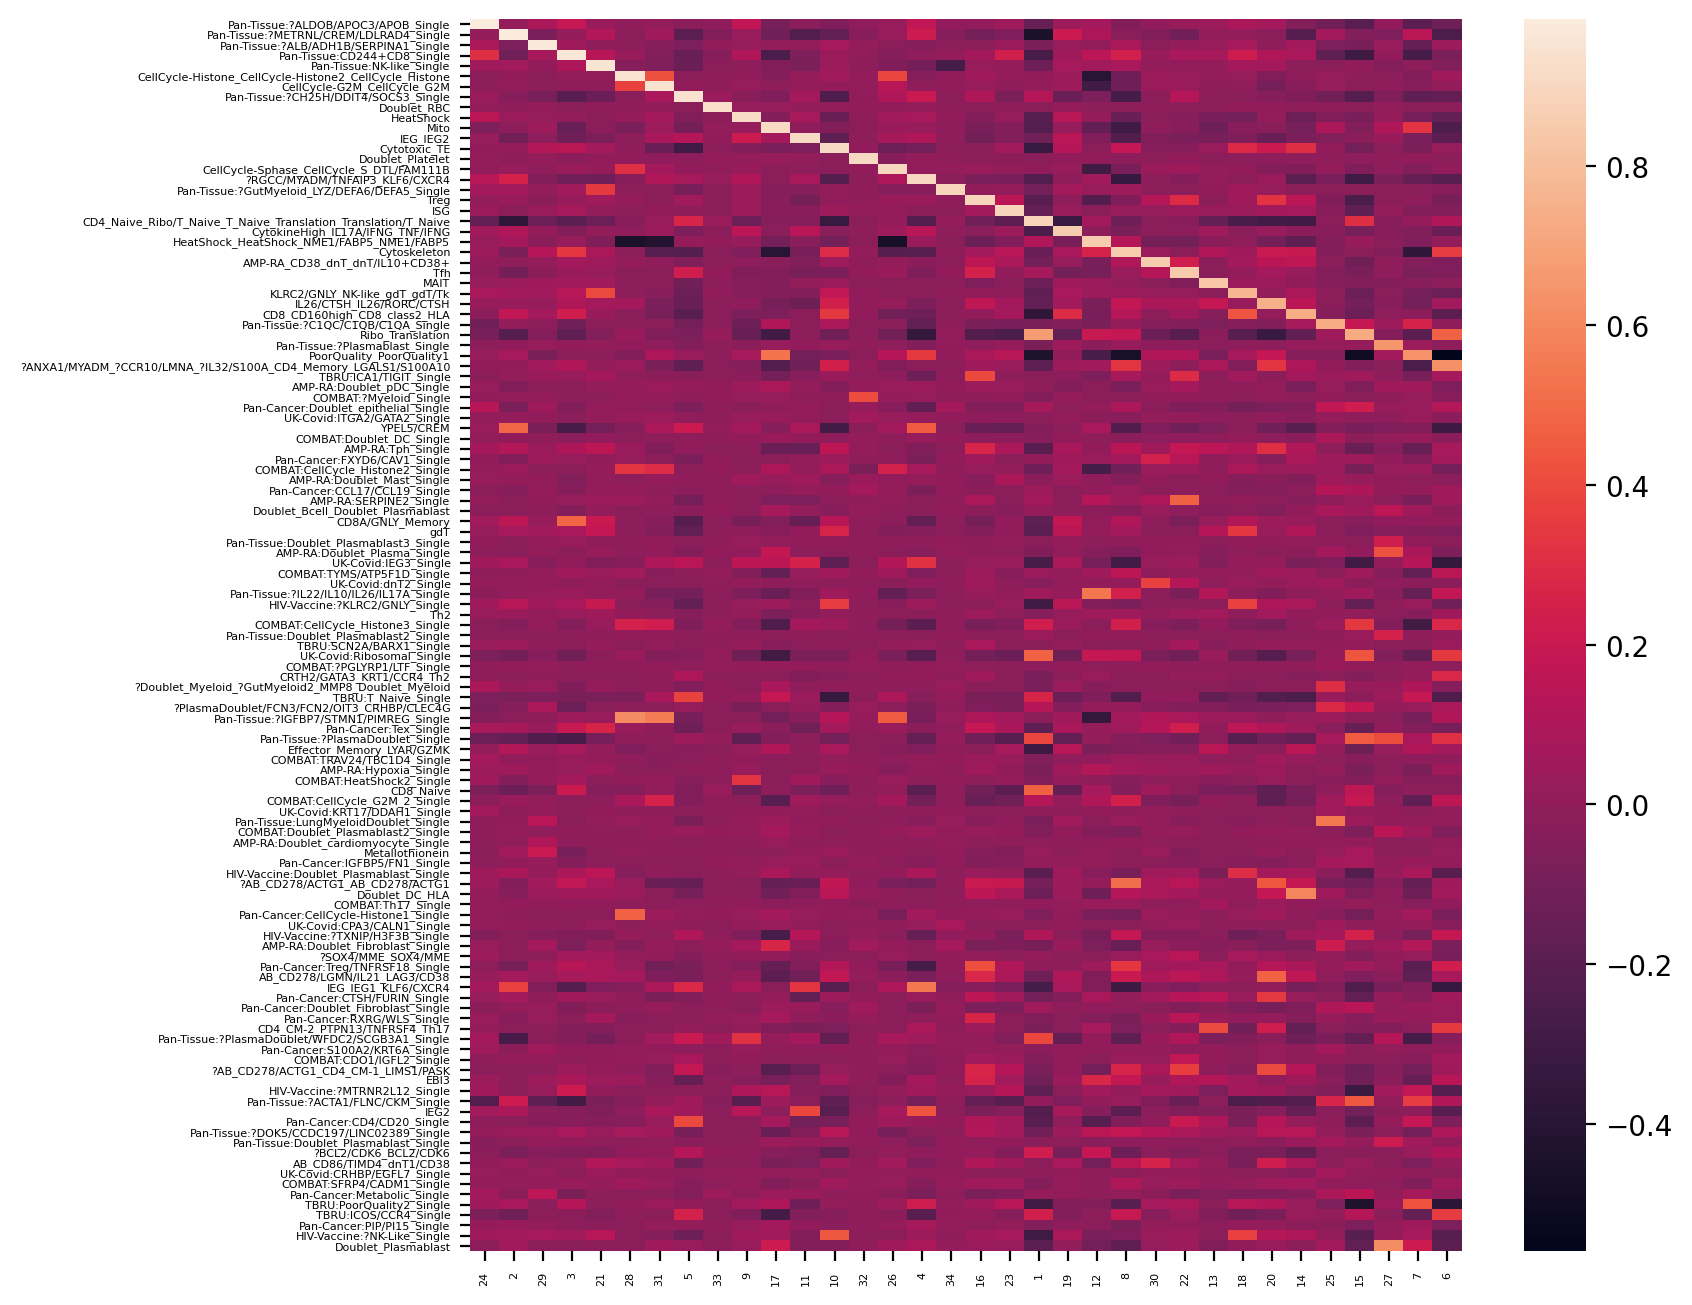

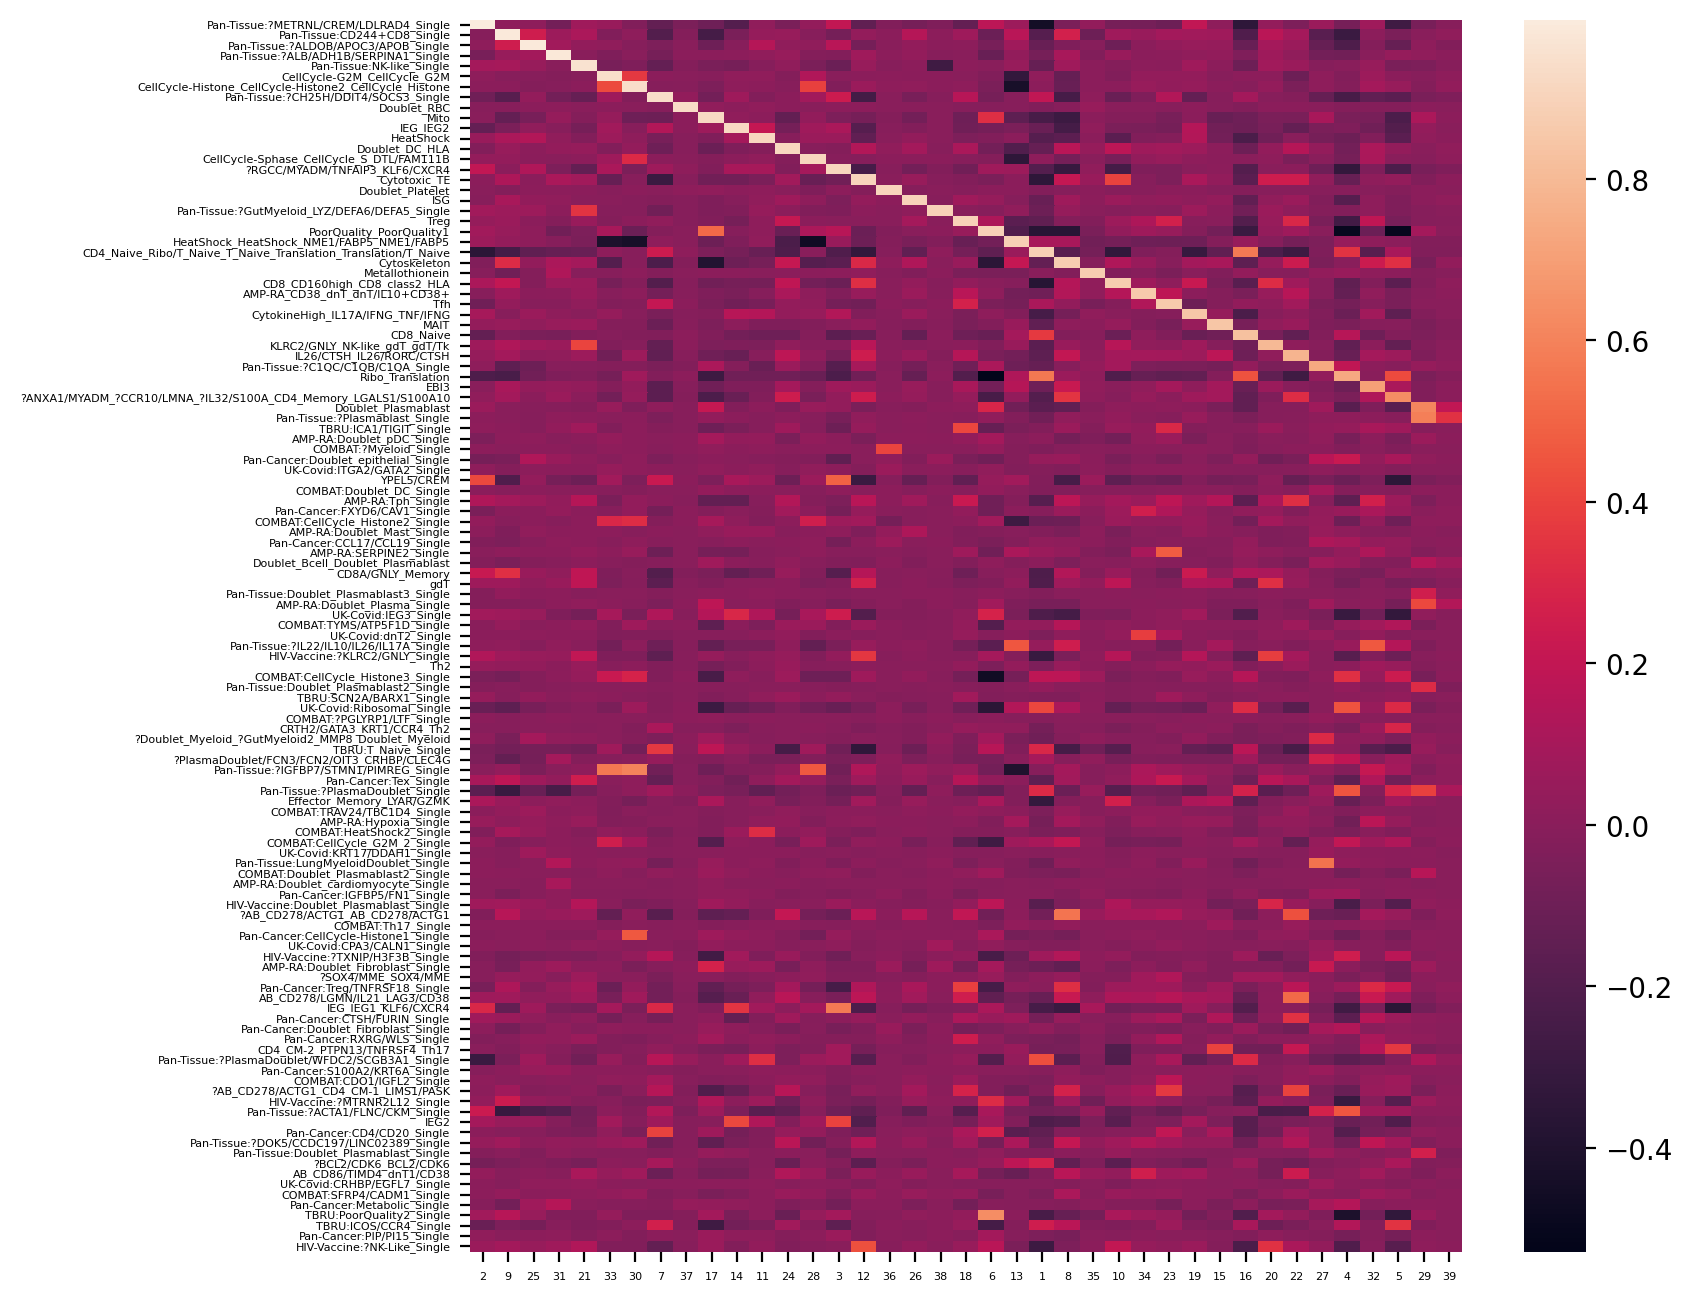

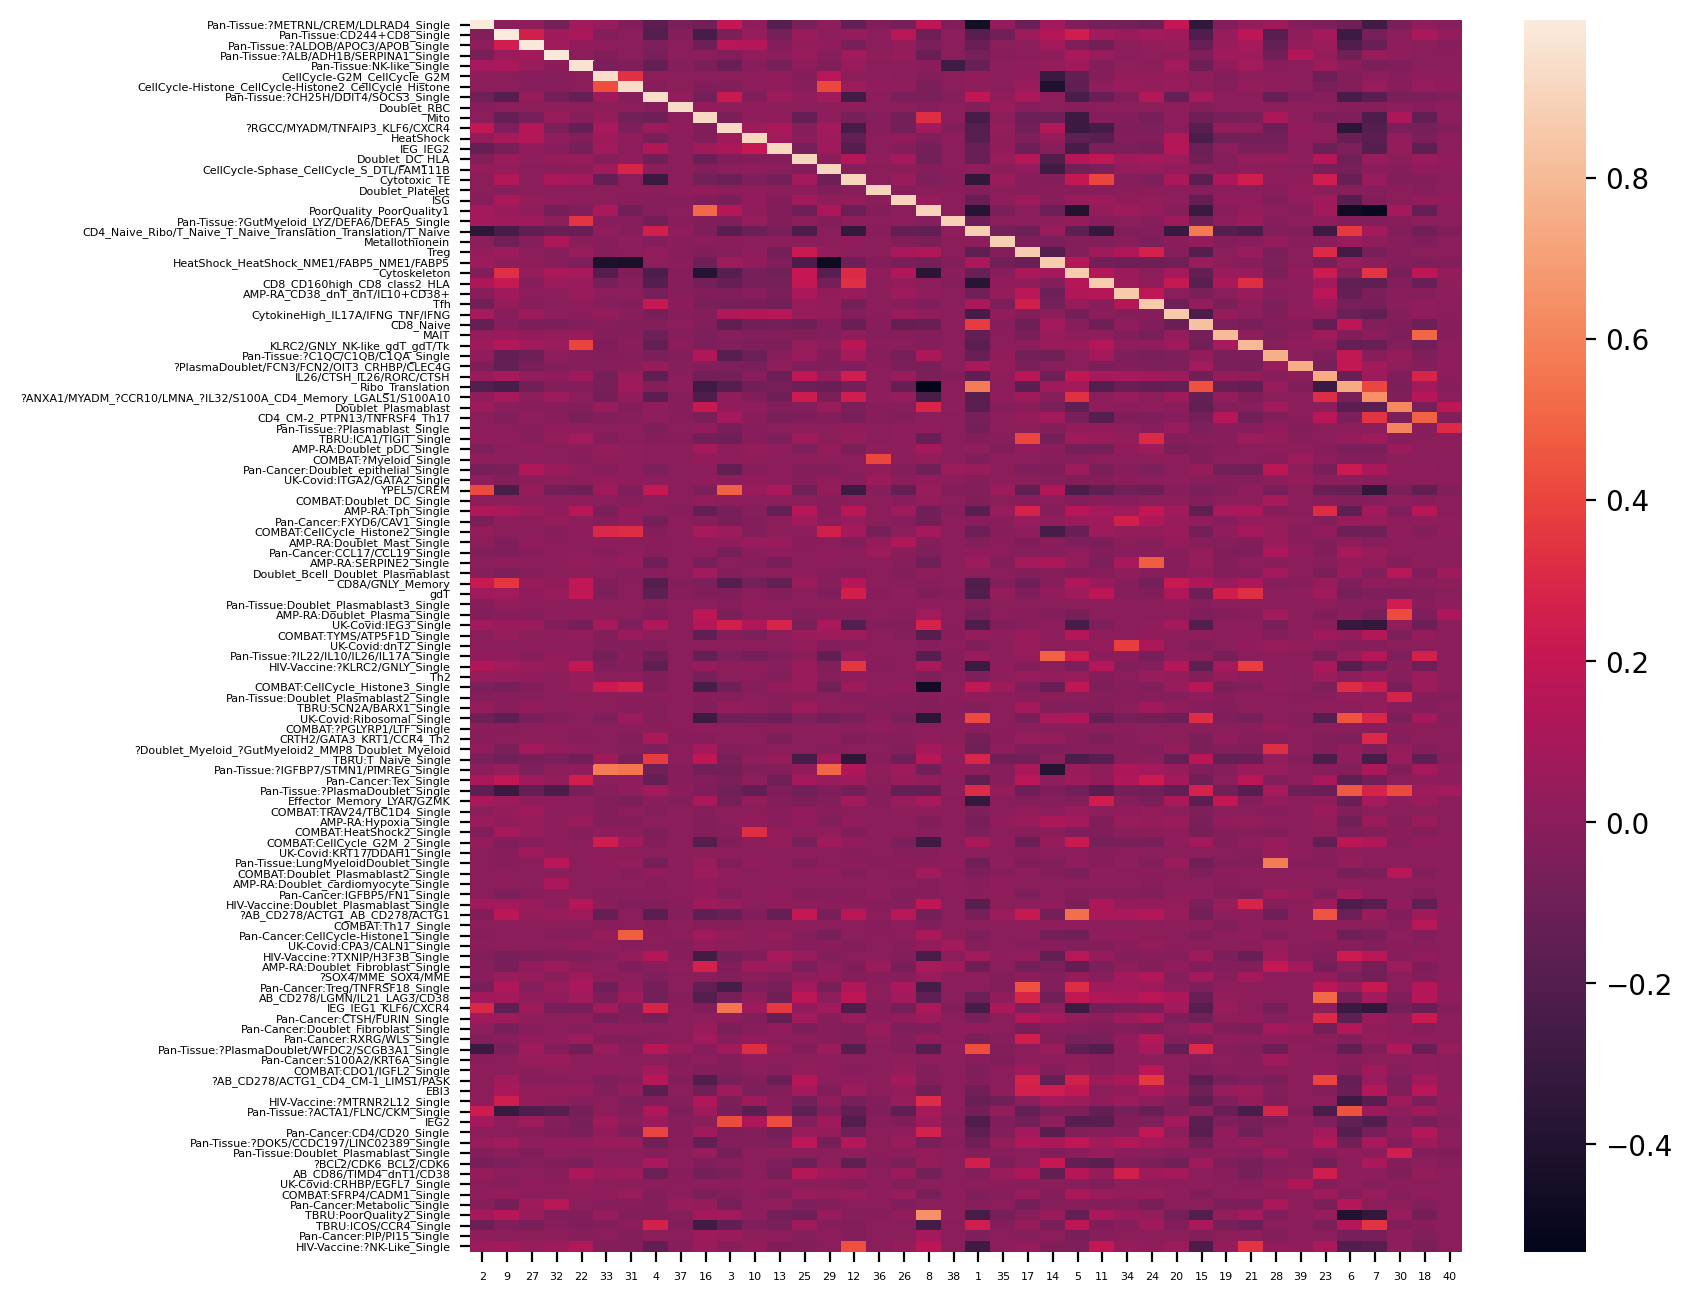

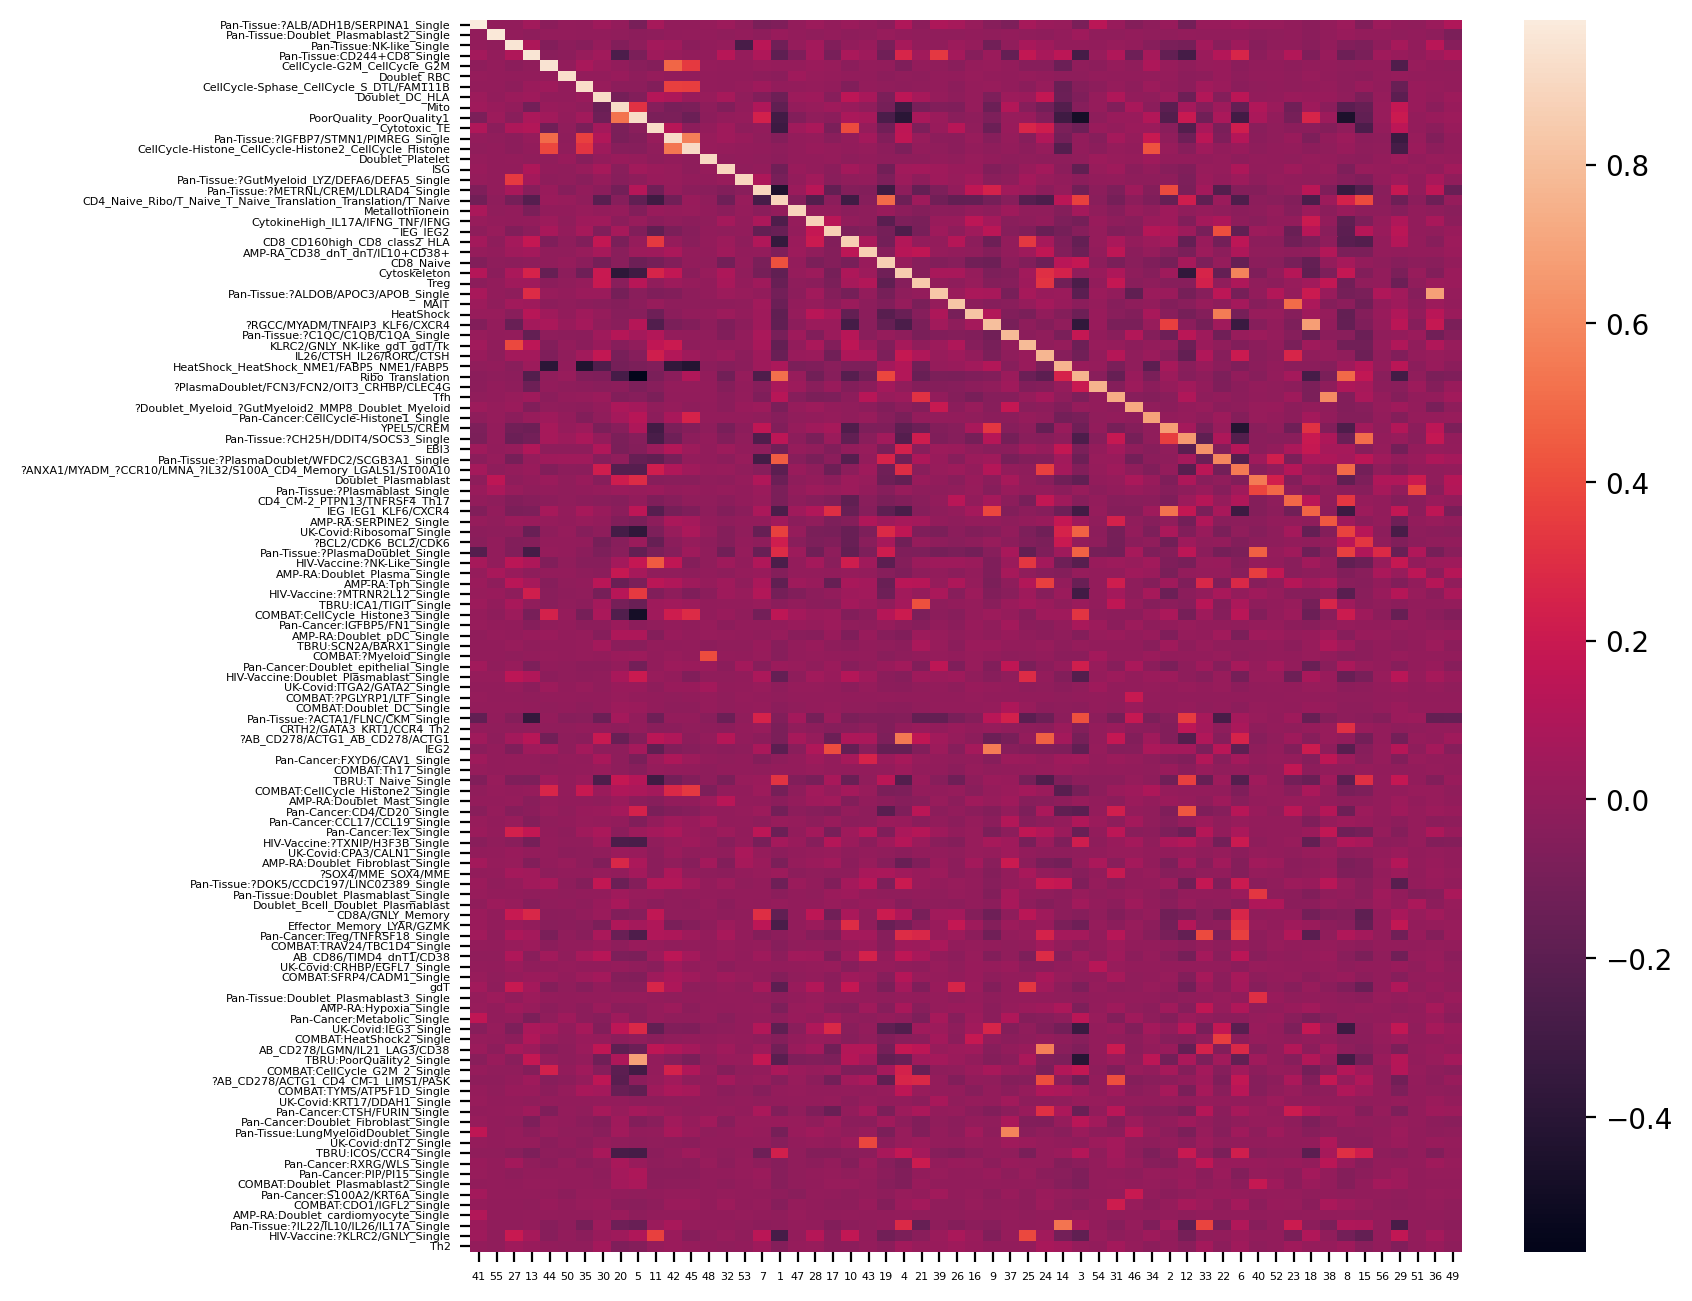

In [340]:
res = []
R_thresh = 0.55
dataset_cols = ['AMP-RA', 'UK-Covid', 'HIV-Vaccine', 'HIV-Vaccine', 'COMBAT', 'TBRU', 'Pan-Cancer']
this_datset = 'Pan-Tissue'
other_dataset_cols = list(set(dataset_cols) - set([this_datset]))
mapping_ref = {}
top_genes_relabeled = {}

for k in [28, 30, 33, 34, 39, 40, 56]:
    (usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
    overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
    mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
    R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
    rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))
    top_genes = top_genes.rename(columns=rename_dict).loc[:, mapping['X_columns']]
    top_genes_relabeled[k] = top_genes

    fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
    sns.heatmap(R_for_plot, ax=ax)
    ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
    ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
    ax.set_xticklabels(R_for_plot.columns, fontsize=4)
    ax.set_yticklabels(R_for_plot.index, fontsize=4)

    merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
    mapping_ref[k] = merge_annotation
    total_overlaps = (merge_annotation['R']>R_thresh).sum()
    ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
    nonsingleton_overlaps = ind.sum()
    this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
    recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
    new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
    res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])


In [341]:
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  28                27                             19   
1  30                29                             20   
2  33                31                             20   
3  34                34                             23   
4  39                38                             28   
5  40                38                             27   
6  56                44                             29   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                            19                      8               1   
1                            19                      9               1   
2                            19                      9               2   
3                            19                      9               0   
4                            19                      8               1   
5                            19                      8               2   
6                            19                     11              12   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  
5                                       0  
6                                       1

In [342]:
set(mapping_ref[39].loc[mapping_ref[39]['R']>R_thresh, 'X_columns']) - set(mapping_ref[34].loc[mapping_ref[34]['R']>R_thresh, 'X_columns'])

{'CD8_Naive',
 'Doublet_DC_HLA',
 'Doublet_Plasmablast',
 'EBI3',
 'Metallothionein'}

In [343]:
set1=40
set2=39
set(mapping_ref[set1].loc[mapping_ref[set1]['R']>R_thresh, 'X_columns']) - set(mapping_ref[set2].loc[mapping_ref[set2]['R']>R_thresh, 'X_columns'])

{'?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G'}

In [344]:
set1=56
set2=39
set(mapping_ref[set1].loc[mapping_ref[set1]['R']>R_thresh, 'X_columns']) - set(mapping_ref[set2].loc[mapping_ref[set2]['R']>R_thresh, 'X_columns'])

{'?Doublet_Myeloid_?GutMyeloid2_MMP8_Doublet_Myeloid',
 '?PlasmaDoublet/FCN3/FCN2/OIT3_CRHBP/CLEC4G',
 'Pan-Cancer:CellCycle-Histone1_Single',
 'Pan-Tissue:?IGFBP7/STMN1/PIMREG_Single',
 'Pan-Tissue:?PlasmaDoublet/WFDC2/SCGB3A1_Single',
 'Pan-Tissue:Doublet_Plasmablast2_Single',
 'YPEL5/CREM'}

In [345]:
set1 = 39
set(mapping_ref[set1].loc[mapping_ref[set1]['R']>R_thresh, 'X_columns'])

{'?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory_LGALS1/S100A10',
 '?RGCC/MYADM/TNFAIP3_KLF6/CXCR4',
 'AMP-RA_CD38_dnT_dnT/IL10+CD38+',
 'CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Translation/T_Naive',
 'CD8_CD160high_CD8_class2_HLA',
 'CD8_Naive',
 'CellCycle-G2M_CellCycle_G2M',
 'CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone',
 'CellCycle-Sphase_CellCycle_S_DTL/FAM111B',
 'CytokineHigh_IL17A/IFNG_TNF/IFNG',
 'Cytoskeleton',
 'Cytotoxic_TE',
 'Doublet_DC_HLA',
 'Doublet_Plasmablast',
 'Doublet_Platelet',
 'Doublet_RBC',
 'EBI3',
 'HeatShock',
 'HeatShock_HeatShock_NME1/FABP5_NME1/FABP5',
 'IEG_IEG2',
 'IL26/CTSH_IL26/RORC/CTSH',
 'ISG',
 'KLRC2/GNLY_NK-like_gdT_gdT/Tk',
 'MAIT',
 'Metallothionein',
 'Mito',
 'Pan-Tissue:?ALB/ADH1B/SERPINA1_Single',
 'Pan-Tissue:?ALDOB/APOC3/APOB_Single',
 'Pan-Tissue:?C1QC/C1QB/C1QA_Single',
 'Pan-Tissue:?CH25H/DDIT4/SOCS3_Single',
 'Pan-Tissue:?GutMyeloid_LYZ/DEFA6/DEFA5_Single',
 'Pan-Tissue:?METRNL/CREM/LDLRAD4_Single',
 'Pan-Tissue:CD24

In [351]:
mapping_ref[39].loc[~mapping_ref[39]['R'].isnull(), :]

Y_columns                                          X_columns  \
219.0         2.0             Pan-Tissue:?METRNL/CREM/LDLRAD4_Single   
1053.0        9.0                        Pan-Tissue:CD244+CD8_Single   
2961.0       25.0                Pan-Tissue:?ALDOB/APOC3/APOB_Single   
3677.0       31.0              Pan-Tissue:?ALB/ADH1B/SERPINA1_Single   
2484.0       21.0                          Pan-Tissue:NK-like_Single   
3808.0       33.0                        CellCycle-G2M_CellCycle_G2M   
3459.0       30.0  CellCycle-Histone_CellCycle-Histone2_CellCycle...   
816.0         7.0               Pan-Tissue:?CH25H/DDIT4/SOCS3_Single   
4291.0       37.0                                        Doublet_RBC   
1914.0       17.0                                               Mito   
1566.0       14.0                                           IEG_IEG2   
1199.0       11.0                                          HeatShock   
2753.0       24.0                                     Doublet_DC_HLA   
3218.0       28.0           CellCycle-Sphase_CellCycle_S_DTL/FAM111B   
269.0         3.0                     ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4   
1323.0       12.0                                       Cytotoxic_TE   
4182.0       36.0                                   Doublet_Platelet   
2977.0       26.0                                                ISG   
4517.0       38.0      Pan-Tissue:?GutMyeloid_LYZ/DEFA6/DEFA5_Single   
2038.0       18.0                                               Treg   
617.0         6.0                           PoorQuality_PoorQuality1   
1452.0       13.0          HeatShock_HeatShock_NME1/FABP5_NME1/FABP5   
35.0          1.0  CD4_Naive_Ribo/T_Naive_T_Naive_Translation_Tra...   
837.0         8.0                                       Cytoskeleton   
4049.0       35.0                                    Metallothionein   
1092.0       10.0                       CD8_CD160high_CD8_class2_HLA   
3960.0       34.0                     AMP-RA_CD38_dnT_dnT/IL10+CD38+   
2655.0       23.0                                                Tfh   
2160.0       19.0                   CytokineHigh_IL17A/IFNG_TNF/IFNG   
1672.0       15.0                                               MAIT   
1814.0       16.0                                          CD8_Naive   
2281.0       20.0                      KLRC2/GNLY_NK-like_gdT_gdT/Tk   
2543.0       22.0                           IL26/CTSH_IL26/RORC/CTSH   
3203.0       27.0                  Pan-Tissue:?C1QC/C1QB/C1QA_Single   
370.0         4.0                                   Ribo_Translation   
3727.0       32.0                                               EBI3   
488.0         5.0  ?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memor...   
3357.0       29.0                                Doublet_Plasmablast   
4637.0       39.0                     Pan-Tissue:?Plasmablast_Single   

               R                    AMP-RA                      UK-Covid  \
219.0   0.997355                       NaN                           NaN   
1053.0  0.986915                       NaN                           NaN   
2961.0  0.985542                       NaN                           NaN   
3677.0  0.984426                       NaN                           NaN   
2484.0  0.958186                       NaN                           NaN   
3808.0  0.945840      AMP-RA:CellCycle-G2M        UK-Covid:CellCycle_G2M   
3459.0  0.942132  AMP-RA:CellCycle-Histone    UK-Covid:CellCycle_Histone   
816.0   0.939547                       NaN                           NaN   
4291.0  0.932200        AMP-RA:Doublet_RBC          UK-Covid:Doublet_RBC   
1914.0  0.922643                       NaN                 UK-Covid:Mito   
1566.0  0.920676                AMP-RA:IEG                 UK-Covid:IEG2   
1199.0  0.918754          AMP-RA:HeatShock                           NaN   
2753.0  0.914939         AMP-RA:Doublet_DC                  UK-Covid:HLA   
3218.0  0.909823   AMP-RA:CellCycle-Sphase          UK-Covid:Ce

In [354]:
k = 39
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
top_genes[32].head(20)

0       TNFRSF4
1          EBI3
2      TNFRSF18
3         IL1R2
4       TNFRSF8
5      MIR155HG
6           LTA
7         CCL22
8           PKM
9         IL1R1
10          VDR
11        IL2RA
12    LINC01943
13         BATF
14        CD177
15        NINJ1
16        LAIR2
17      TNFRSF9
18       PTP4A3
19        DNPH1
Name: 32, dtype: object

# K=39

In [355]:
paths

{'Original': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927metadata.tsv',
 'TP10K': '../../../Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.TP10K.h5ad'}

In [356]:
os.path.abspath(paths['RNA_Varnorm_Harmony'])

'/data/srlab1/TCAT/Data/PerDataset/XTissueImmuneAtlas/T.counts.NoBlood.20230927RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [357]:
cnmfdir = '../../../Data/PerDataset/XTissueImmuneAtlas'
name = 'XTissue.20230927.NoBlood.Iter200'

In [358]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(39, 40)
n_iter = 200
num_per_node = 4

In [359]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [361]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [216]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [217]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.0.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name XTissue.20230927.NoBlood.Iter200 --output-dir ../../../Data/PerDataset/XTissueImmuneAtlas --total-workers 50 --worker-index 0"
Job <879241> is submitted to queue <short>.
bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.1.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.1.er

In [224]:
! bjobs

No unfinished job found


In [225]:
! bjobs | wc -l

No unfinished job found
0


In [226]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [227]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

5

In [228]:
missing

[148, 149, 159, 198, 199]

In [229]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [230]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.148.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.148.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name XTissue.20230927.NoBlood.Iter200 --output-dir ../../../Data/PerDataset/XTissueImmuneAtlas --total-workers 200 --worker-index 148"
Job <879296> is submitted to queue <short>.
bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.149.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Ite

In [232]:
! bjobs

No unfinished job found


## Look at the results for K=39 with 200 iterations

In [233]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=39.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


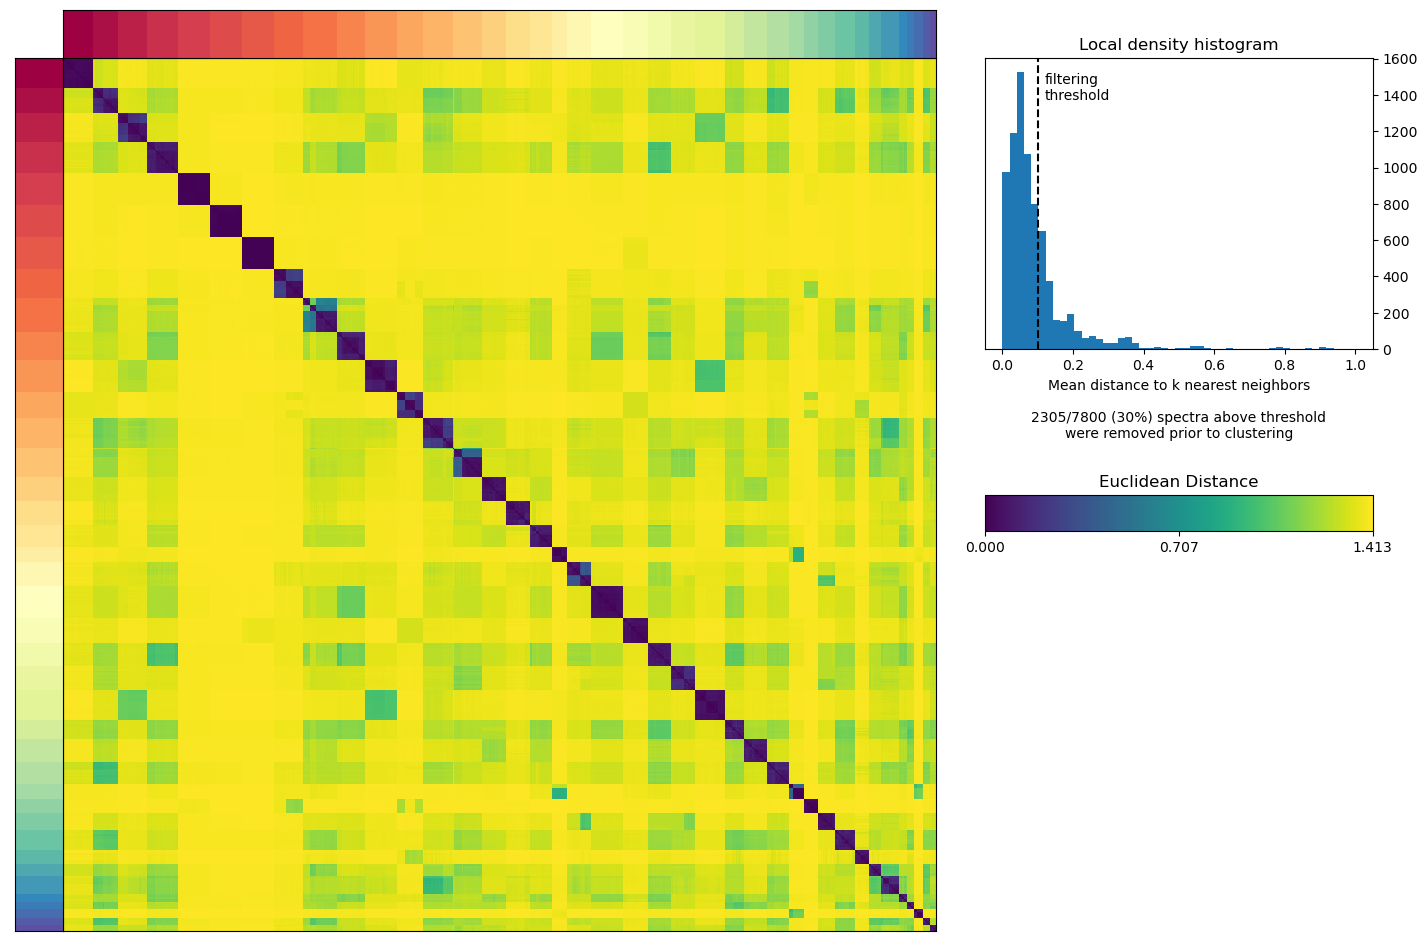

In [379]:
cnmf_obj.consensus(k=39, density_threshold=0.1)

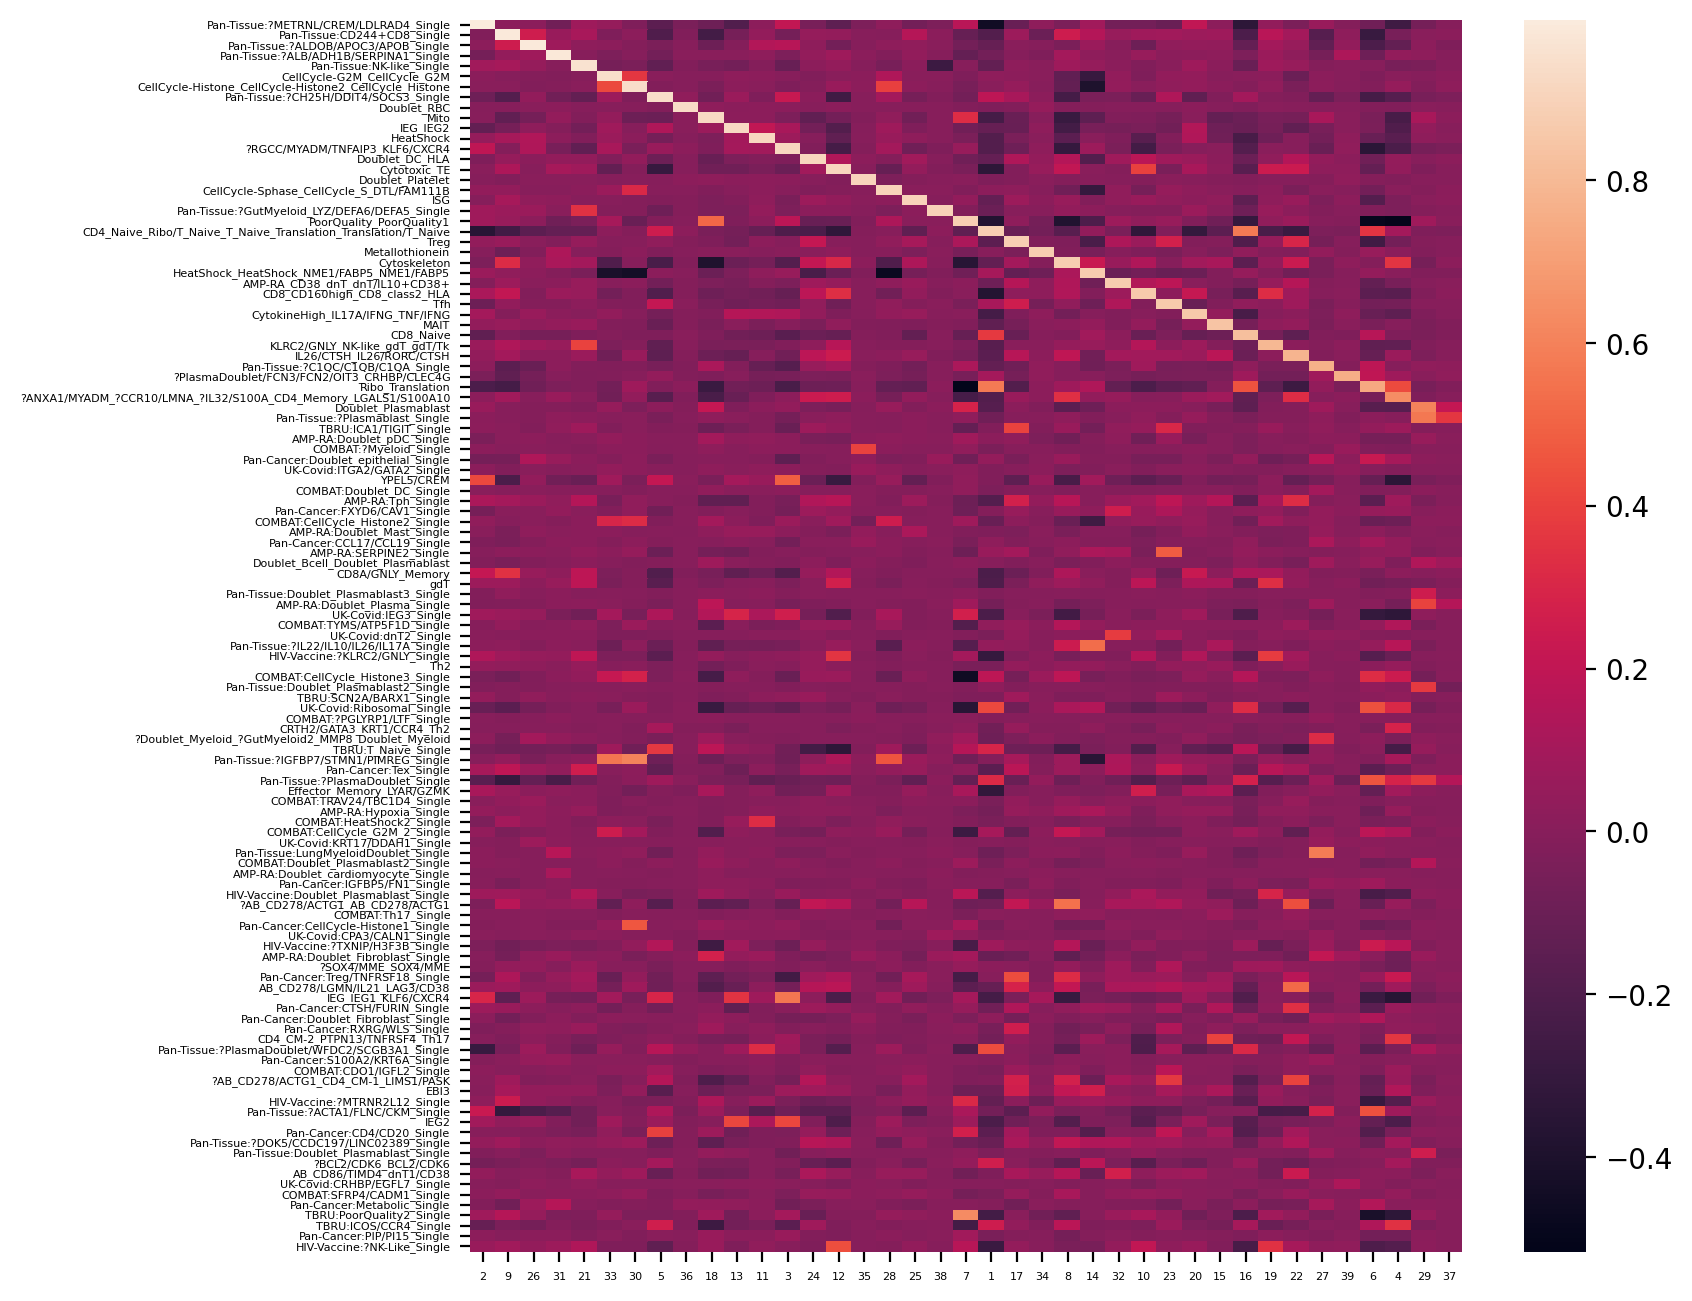

In [384]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=39, density_threshold=0.15)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [385]:
res = []
k=39
merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  39                38                             27   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                            19                      8               1   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0

In [386]:
mapping_ref[k].loc[mapping_ref[k]['X_columns'].apply(lambda x: 'EBI3' in x), :]

Y_columns X_columns   R       AMP-RA UK-Covid Pan-Tissue HIV-Vaccine  \
NaN        NaN      EBI3 NaN  AMP-RA:EBI3      NaN        NaN         NaN   

    COMBAT TBRU       Pan-Cancer  
NaN    NaN  NaN  Pan-Cancer:EBI3

In [387]:
top_genes[17]

0         FOXP3
1         IL2RA
2     LINC01943
3         CTLA4
4       TNFRSF4
        ...    
95        USP15
96          SMS
97        DNAH8
98        CEBPA
99        SGPP2
Name: 17, Length: 100, dtype: object

In [388]:
os.path.abspath(cnmfdir)

'/data/srlab1/TCAT/Data/PerDataset/XTissueImmuneAtlas'

In [389]:
name

'XTissue.20230927.NoBlood.Iter200'

In [390]:
os.path.abspath('.')

'/data/srlab1/TCAT/Analysis/PerDataset/XTissueImmuneAtlas'

In [391]:
gep_info = read_dataset_log('GEP_Name')
gep_info.index = gep_info['MetaGep_Name']
gep_info.head()

MetaGep_Name  \
MetaGep_Name                                                                         
CellCycle-G2M_CellCycle_G2M                            CellCycle-G2M_CellCycle_G2M   
ISG                                                                            ISG   
gdT                                                                            gdT   
Metallothionein                                                    Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  CellCycle-Sphase_CellCycle_S_DTL/FAM111B   

                                                            Long_Name  \
MetaGep_Name                                                            
CellCycle-G2M_CellCycle_G2M                      Cell Cycle G2M Phase   
ISG                                       Interferon Stimulated Genes   
gdT                                               Gamma Delta T Blood   
Metallothionein                                       Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B           Cell Cycle S Phase   

                                               Short_Name Needs Review  \
MetaGep_Name                                                             
CellCycle-G2M_CellCycle_G2M                 CellCycle-G2M          NaN   
ISG                                                   ISG          NaN   
gdT                                             gdT-Blood          NaN   
Metallothionein                           Metallothionein          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      CellCycle-S          NaN   

                                                   Class  Num_Datasets Flag  
MetaGep_Name                                                                 
CellCycle-G2M_CellCycle_G2M               Known Activity             7  NaN  
ISG                                       Known Activity             7  NaN  
gdT                                        Known Lineage             4  NaN  
Metallothionein                           Known Activity             5  NaN  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Known Activity             7  NaN

In [392]:
gep2meta = dict(zip(mapping['Y_columns'], mapping['X_columns']))
meta2rename = dict(zip(gep_info['MetaGep_Name'], gep_info['Short_Name']))
meta2rename['HIV-Vaccine:?TXNIP/H3F3B_Single'] = 'HIV-Vaccine:?TXNIP/H3F3B_Single'
count = 1
gep2rename = {}
for g in gep2meta.keys():
    if gep2meta[g] in meta2rename:
        gep2rename[g] = meta2rename[gep2meta[g]]
    else:
        gep2rename[g] = 'Pan-Tissue:%d' % count
        count += 1

In [393]:
fixmap = {}
fixmap['Pan-Tissue:1'] = 'Pan-Tissue:Digestive/Liver'
fixmap['Pan-Tissue:2'] = 'Pan-Tissue:Liver-Metabolism'
fixmap['Pan-Tissue:3'] = 'Pan-Tissue:Paneth'
fixmap['Pan-Tissue:4'] = 'Pan-Tissue:Macrophage'
fixmap['Pan-Tissue:5'] = 'Pan-Tissue:Plasma'

for g in gep2rename.keys():
    if gep2rename[g] in fixmap.keys():
        gep2rename[g] = fixmap[gep2rename[g]]
        

In [394]:
usage_rename = usage.rename(columns=gep2rename)
spectra_scores_rename = spectra_scores.rename(columns=gep2rename)
spectra_tpm_rename = spectra_tpm.rename(columns=gep2rename)

In [395]:
for dat, lab in [(usage_rename, 'Usage'), (spectra_scores_rename, 'Spectra_Scores'), (spectra_tpm_rename, 'Spectra_TPM')]:
    fn = os.path.join(cnmfdir, name +'.'+lab+'.Relabeled.tsv')
    print(os.path.abspath(fn))
    dat.to_csv(fn, sep='\t')

/data/srlab1/TCAT/Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200.Usage.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200.Spectra_Scores.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200.Spectra_TPM.Relabeled.tsv


In [396]:
top_genes_relabed = {}
for g in spectra_scores_rename.columns:
    top_genes_relabed[g] = spectra_scores_rename[g].sort_values(ascending=False).iloc[:50].index
    
top_genes_relabed = pd.DataFrame.from_dict(top_genes_relabed).T

In [397]:
top_genes_relabed.iloc[:, :20]

0          1          2         3   \
CD4-Naive                         RPS8      RPS13      RPS12     RPS23   
METRNL/CREM                       CREM     METRNL    LDLRAD4    PARD6G   
RGCC/MYADM                        RGCC      MYADM    TNFAIP3       EZR   
S100A10/LMNA                   S100A11      TIMP1        LTB    S100A4   
CH25H/DDIT4                      CH25H      SOCS3    ZFP36L2     DDIT4   
Translation                      RPS11      RPL23     RPL13A     RPS10   
MALAT1                          MALAT1  LINC-PINT      NEAT1    GOLGB1   
Cytoskeleton                     ACTG1       ACTB       PFN1      CFL1   
CD244/CD8                         CAPG      CD244     HMGCS1      CD8B   
CD8_EM                            GZMK       CMC1       CST7     EOMES   
HeatShock1                      HSPA1A   HSP90AA1      HSPD1     HSPH1   
Cytotoxic                       FGFBP2       GZMH       NKG7      GZMB   
IEG-Tissue                        IER2       EGR1        FOS       JUN   
HeatShock2                        NME1        SRM       ENO1     C1QBP   
MAIT                             IL4I1      IL23R    SLC4A10     CEBPD   
CD8-Naive                    LINC02446      S100B       YBX3     NELL2   
Treg                             FOXP3      IL2RA  LINC01943     CTLA4   
Mito                            MT-CO1     MT-CYB     MT-CO2    MT-CO3   
gdT                            KIR2DL3    KIR3DL1    KIR3DL2     TRDV1   
High-Cytokine                   CCL4L2       CCL4       XCL2      XCL1   
NK-Like-3                       FCER1G       GZMA      KRT81     KRT86   
IL26/CTSH                          MAF       CTSH     COL5A3      FUT7   
Tfh                              CD200       KSR2       MAP7    MS4A6A   
HLA                            HLA-DRA   HLA-DRB1   HLA-DQA1      CD74   
ISG                              IFIT3      IFIT2      IFIT1     ISG15   
Pan-Tissue:Digestive/Liver       PHGR1       RBP2      ALDOB     FABP1   
Pan-Tissue:Macrophage             C1QC       C1QB       C1QA      CD5L   
CellCycle-S                       TYMS      PCLAF        TK1      CDT1   
Doublet-Plasma                  JCHAIN      IGHA1   IGKV3-20      IGKC   
CellCycle-Histone             HIST1H3G   HIST1H4C   HIST1H1B  HIST1H3B   
Pan-Tissue:Liver-Metabolism        ALB   SERPINA1       MT1G     ADH1B   
IL10/CD38                         CAV1      FXYD2      PTPN3      CRYM   
CellCycle-G2M                    UBE2C      CCNB2      CDC20      PLK1   
Metallothionein                   MT2A       MT1X       MT1E      MT1F   
Doublet-Platelet                  PPBP      TUBB1        PF4    CAVIN2   
Doublet-RBC                        HBB       HBA2       HBA1       HBM   
Pan-Tissue:Plasma             IGLV2-23   IGHV3-48   IGHV3-41  IGHV3-21   
Pan-Tissue:Paneth                DEFA5      DEFA6    PLA2G2A     REG3A   
FCN3/FCN2                         FCN3       FCN2      CCL14      OIT3   

                                   4          5         6          7   \
CD4-Naive                        SELL      RPL19     RPL32      RPL29   
METRNL/CREM                    ATP1B3     PTPN22     AUTS2       FTH1   
RGCC/MYADM                       LMNA       PIM3     ANXA1       JUND   
S100A10/LMNA                     EMP3     S100A6   S100A10       NEFL   
CH25H/DDIT4                      EPGN      SOCS1     CMTM8       AREG   
Translation                     RPS17      RPS20    RPL27A       RPL7   
MALAT1                       HIST1H1D      PTPRC     SYNE2  LINC00513   
Cytoskeleton                   CORO1A     ARPC1B      MYL6      COTL1   
CD244/CD8                       ITGAE       ABI3     CD160      TRGV2   
CD8_EM                         SH2D1A      DTHD1     KLRG1       LYST   
HeatShock1                      HSPE1     DNAJB1     HSPB1     CACYBP   
Cytotoxic                        PRF1     FCGR3A    ADGRG1     CX3CR1   
IEG-Tissue                       BTG2       JUNB     DUSP1       FOSB   
HeatShock2                       NME2      FABP5     

In [398]:
adata = sc.read(paths['RNA_Varnorm_Harmony'])

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [399]:
adata

AnnData object with n_obs × n_vars = 154314 × 2000
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'Sex', 'Age_range', 'pct_mito', 'n_counts'
    var: 'gene', 'features_renamed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [400]:
tissue_average = usage_rename.groupby(adata.obs['Organ']).mean()

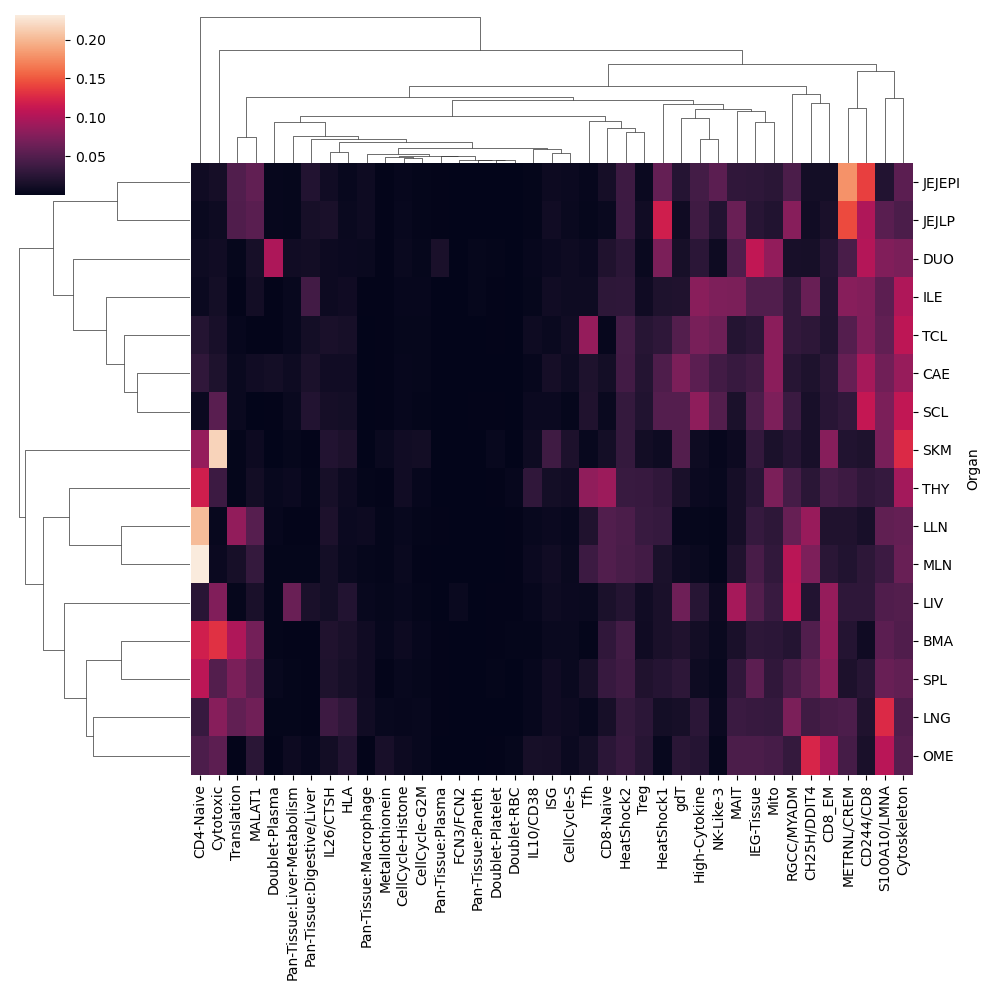

In [401]:
sns.clustermap(tissue_average)

In [402]:
cols = [x for x in usage_rename.columns if 'Pan-Tissue' in x]
tissue_average[cols]

Pan-Tissue:Digestive/Liver  Pan-Tissue:Macrophage  \
Organ                                                       
BMA                       0.000969               0.009589   
CAE                       0.016969               0.000606   
DUO                       0.011525               0.005877   
ILE                       0.040363               0.001304   
JEJEPI                    0.021696               0.008327   
JEJLP                     0.014480               0.008393   
LIV                       0.016031               0.005020   
LLN                       0.001541               0.007685   
LNG                       0.001505               0.010793   
MLN                       0.002558               0.003334   
OME                       0.003818               0.001133   
SCL                       0.021152               0.000090   
SKM                       0.001369               0.000606   
SPL                       0.001799               0.009240   
TCL                       0.012041               0.000780   
THY                       0.002223               0.002388   

        Pan-Tissue:Liver-Metabolism  Pan-Tissue:Plasma  Pan-Tissue:Paneth  
Organ                                                                      
BMA                        0.001074           0.001031           0.000202  
CAE                        0.009016           0.000554           0.000378  
DUO                        0.010601           0.015901           0.002784  
ILE                        0.005028           0.000154           0.003016  
JEJEPI                     0.003035           0.001185           0.000485  
JEJLP                      0.003189           0.001293           0.000575  
LIV                        0.063332           0.000605           0.000466  
LLN                        0.001659           0.001119           0.000440  
LNG                        0.002587           0.000964           0.000253  
MLN                        0.002573           0.000735           0.000183  
OME                        0.008064           0.000145           0.000864  
SCL                        0.006257           0.000142           0.001562  
SKM                        0.003470           0.000185           0.000042  
SPL                        0.002156           0.001299           0.000216  
TCL                        0.004848           0.000265           0.000921  
THY                        0.006791           0.000580           0.000293

## Try again with K=40 to try and salvage EBI3 activation program

In [403]:
cnmfdir = '../../../Data/PerDataset/XTissueImmuneAtlas'
name = 'XTissue.20230927.NoBlood.Iter200'

In [404]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(40, 41)
n_iter = 200
num_per_node = 4

In [405]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [406]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [407]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [408]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.0.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name XTissue.20230927.NoBlood.Iter200 --output-dir ../../../Data/PerDataset/XTissueImmuneAtlas --total-workers 50 --worker-index 0"
Job <883783> is submitted to queue <short>.
bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.1.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.1.er

In [409]:
! bjobs

JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
883793  dk718   RUN   short      cn071       cmu122      *d.Iter200 Oct  5 11:39
883789  dk718   RUN   short      cn071       cmu073      *d.Iter200 Oct  5 11:39
883791  dk718   RUN   short      cn071       cmu065      *d.Iter200 Oct  5 11:39
883790  dk718   RUN   short      cn071       cmu087      *d.Iter200 Oct  5 11:39
883792  dk718   RUN   short      cn071       cmu081      *d.Iter200 Oct  5 11:39
883796  dk718   RUN   short      cn071       cmu102      *d.Iter200 Oct  5 11:39
883797  dk718   RUN   short      cn071       cmu118      *d.Iter200 Oct  5 11:39
883788  dk718   RUN   short      cn071       cmu091      *d.Iter200 Oct  5 11:39
883794  dk718   RUN   short      cn071       cmu106      *d.Iter200 Oct  5 11:39
883795  dk718   RUN   short      cn071       cmu114      *d.Iter200 Oct  5 11:39
883785  dk718   RUN   short      cn071       cn008       *d.Iter200 Oct  5 11:39
883800  dk718   RUN   short  

In [415]:
! bjobs | wc -l

3


In [416]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [423]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [424]:
missing

[]

In [425]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [426]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

In [427]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=40.



KeyboardInterrupt



Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


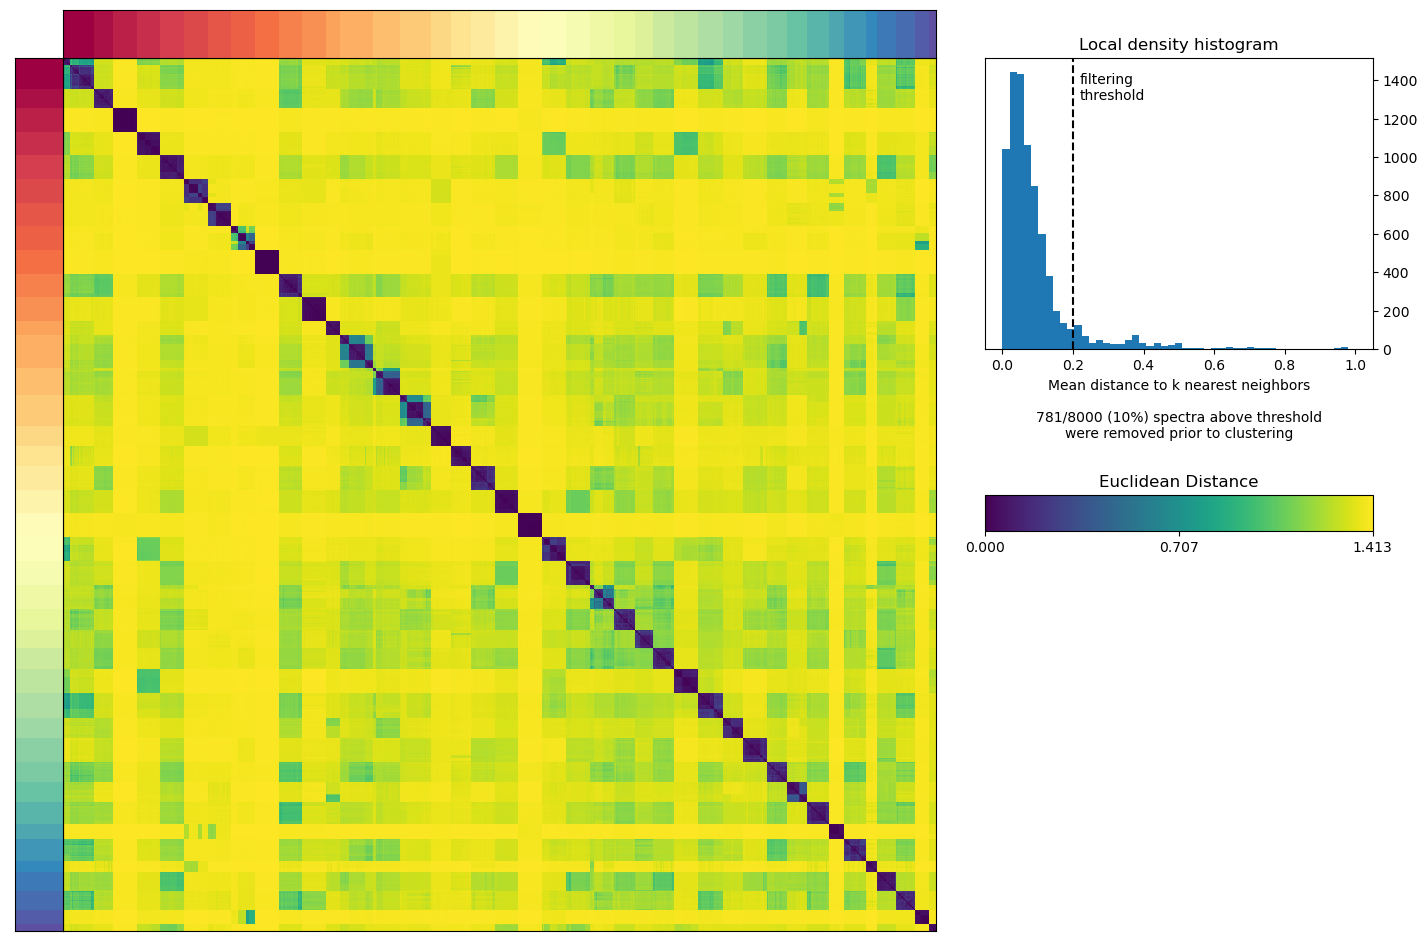

In [437]:
cnmf_obj.consensus(k=40, density_threshold=0.2)

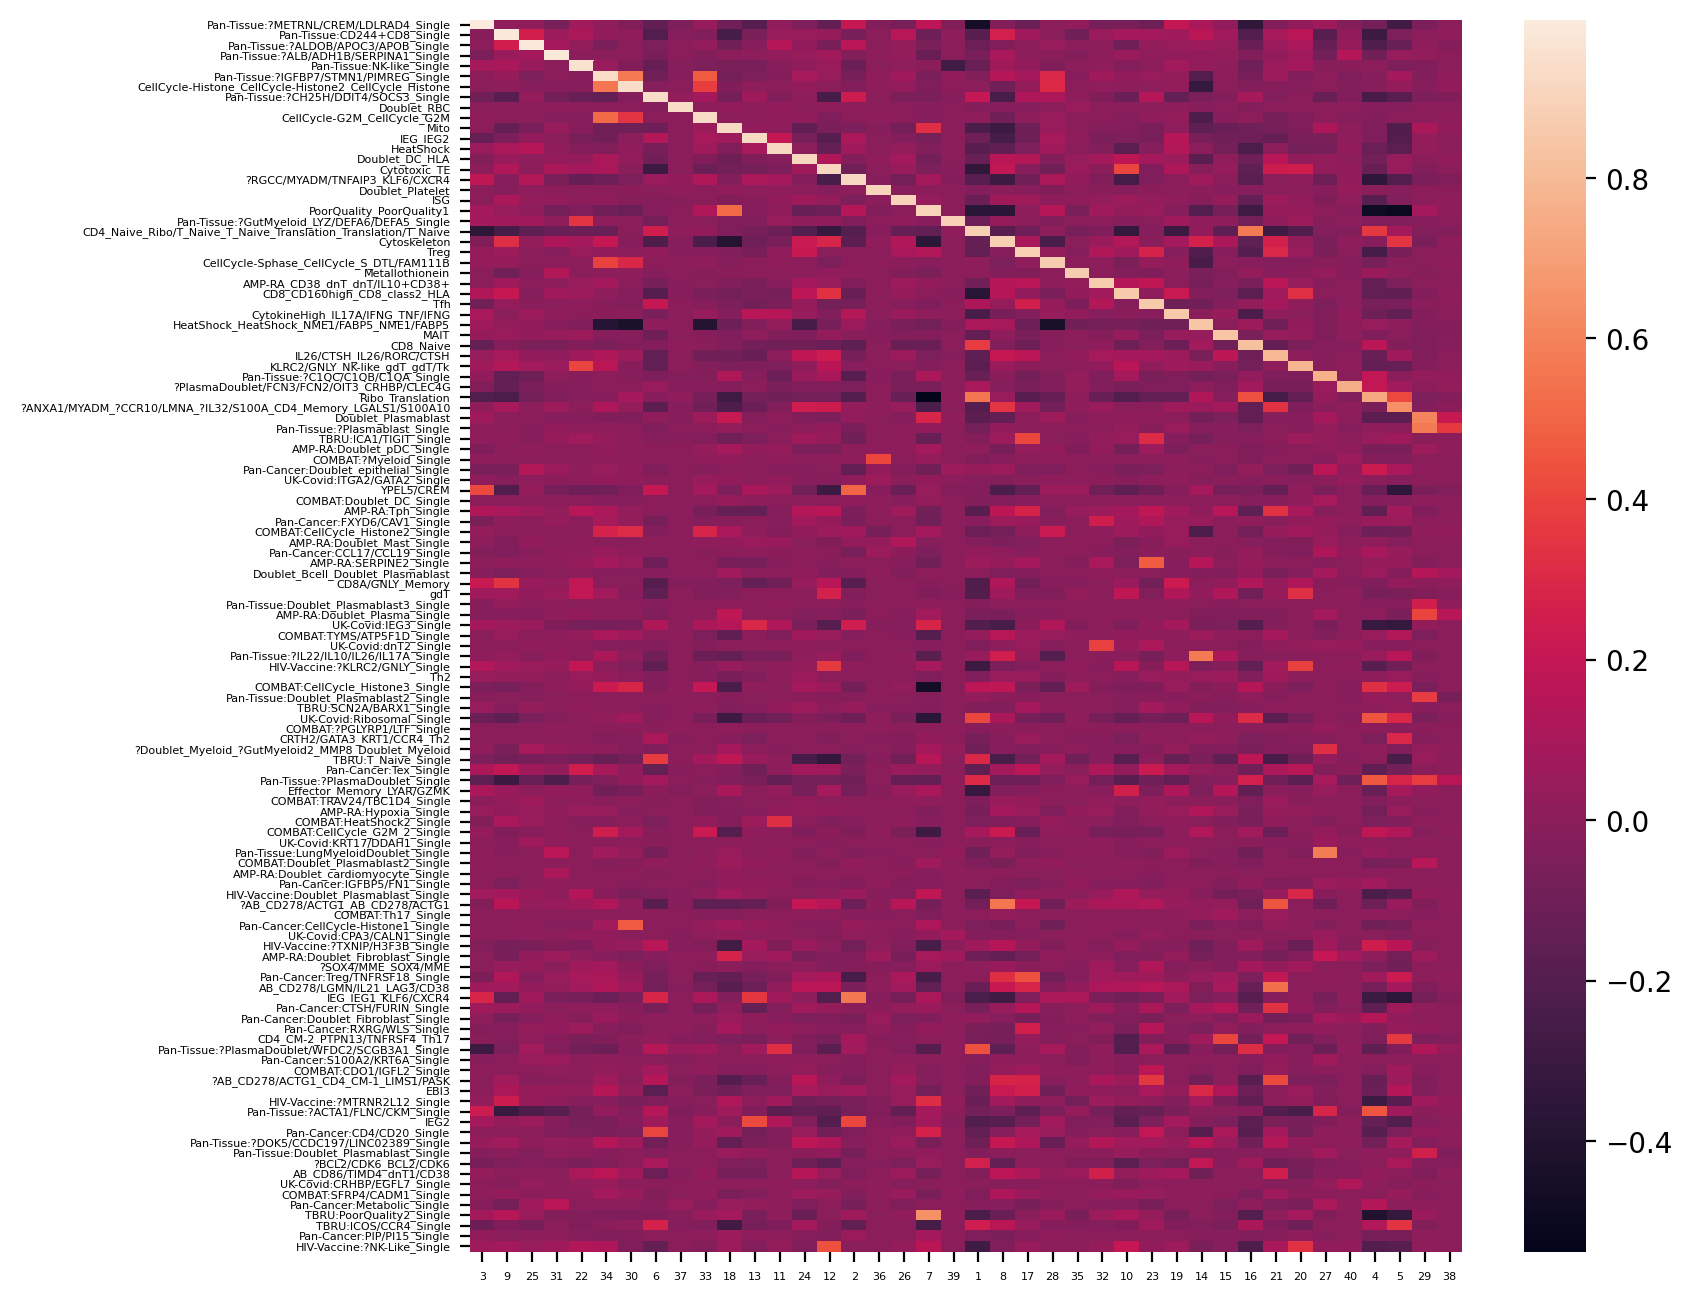

In [475]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=40, density_threshold=0.2)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [476]:
[x for x in mapping['X_columns'] if 'EBI3' in x]

[]

In [477]:
mapping.shape

(40, 3)

## Try again with K=42 to try and salvage EBI3 activation program

In [439]:
cnmfdir = '../../../Data/PerDataset/XTissueImmuneAtlas'
name = 'XTissue.20230927.NoBlood.Iter200'

In [440]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(42, 43)
n_iter = 200
num_per_node = 4

In [441]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

50

In [442]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [443]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [444]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.0.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name XTissue.20230927.NoBlood.Iter200 --output-dir ../../../Data/PerDataset/XTissueImmuneAtlas --total-workers 50 --worker-index 0"
Job <883955> is submitted to queue <short>.
bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.1.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.1.er

In [454]:
! bjobs

No unfinished job found


In [455]:
! bjobs | wc -l

No unfinished job found
0


In [456]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [457]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            #print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

28

In [458]:
missing

[7,
 16,
 56,
 57,
 58,
 66,
 67,
 106,
 107,
 108,
 116,
 117,
 118,
 152,
 156,
 157,
 158,
 159,
 165,
 166,
 167,
 168,
 172,
 174,
 177,
 178,
 181,
 187]

In [459]:
total_workers = int((len(Ks)*n_iter))
total_workers

200

In [460]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.7.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.7.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name XTissue.20230927.NoBlood.Iter200 --output-dir ../../../Data/PerDataset/XTissueImmuneAtlas --total-workers 200 --worker-index 7"
Job <884207> is submitted to queue <short>.
bsub -q short -J XTissue.20230927.NoBlood.Iter200 -o ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.16.out.txt -e ../../../Data/PerDataset/XTissueImmuneAtlas/XTissue.20230927.NoBlood.Iter200/log/XTissue.20230927.NoBlood.Iter200.16

In [464]:
! bjobs | wc -l

No unfinished job found
0


In [465]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=42.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


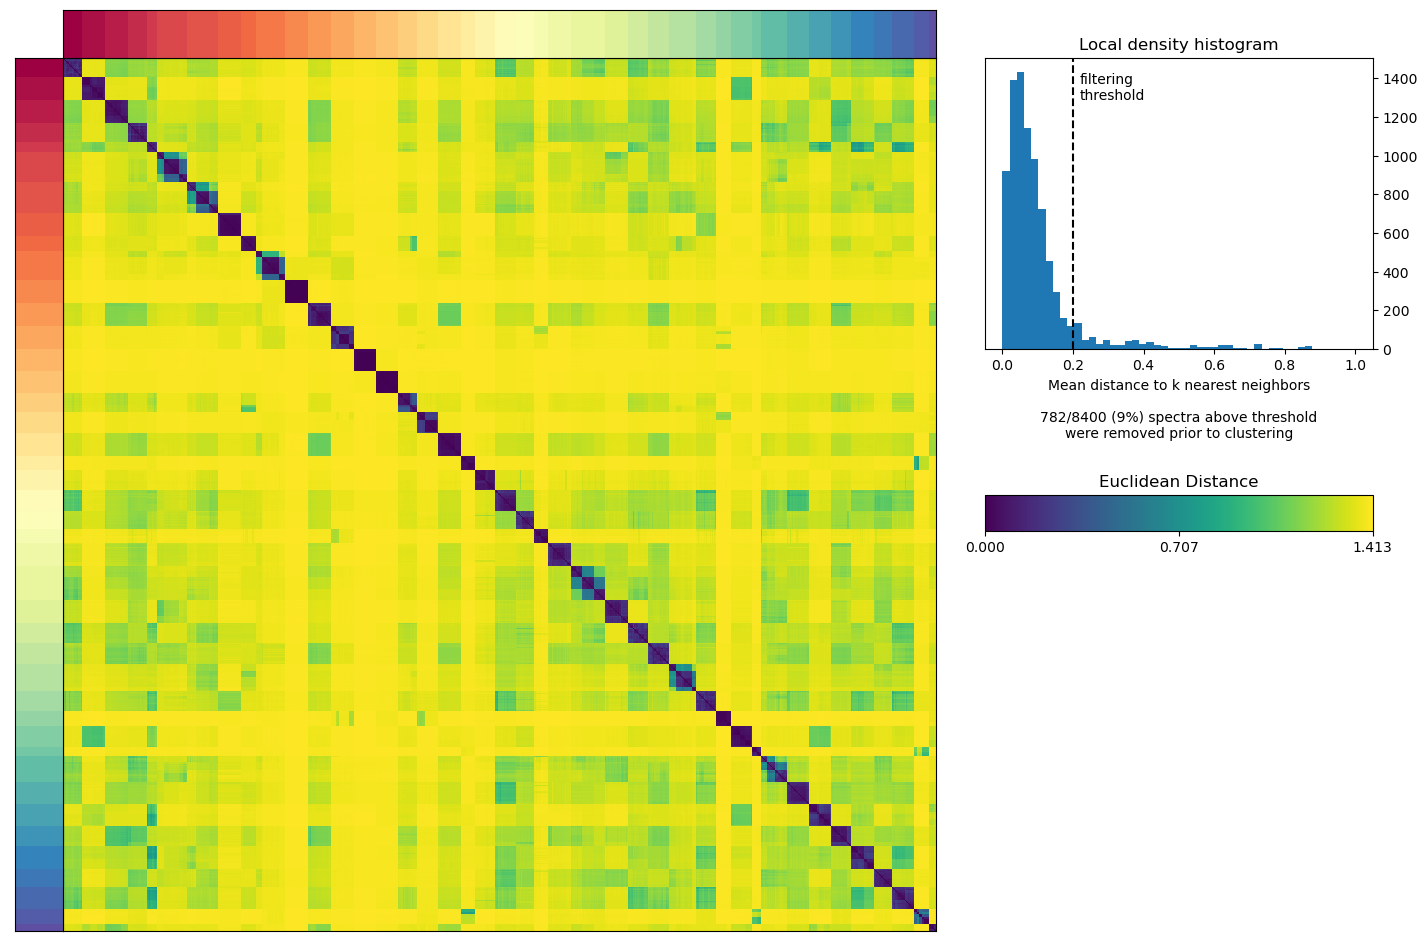

In [466]:
cnmf_obj.consensus(k=42, density_threshold=0.2)

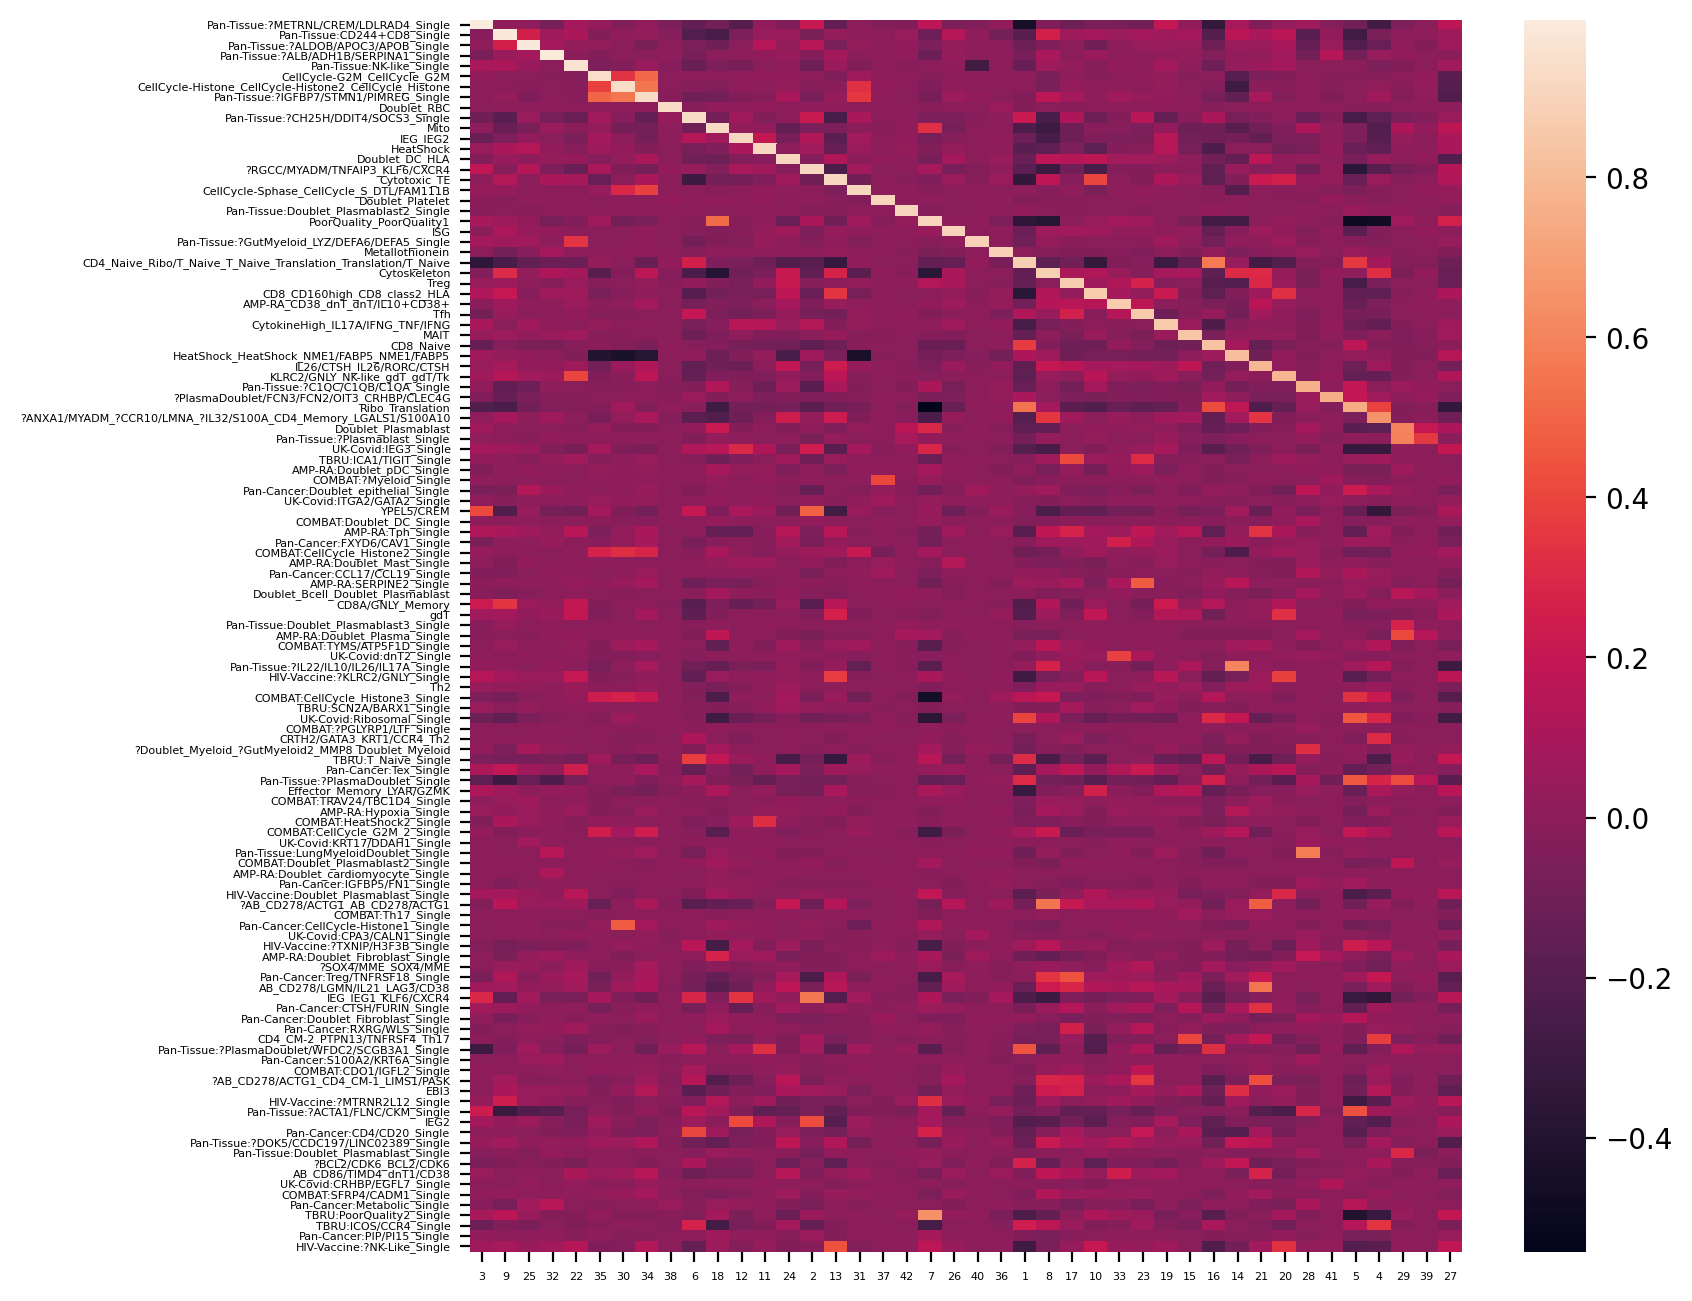

In [467]:
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=42, density_threshold=0.2)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [474]:
[x for x in mapping['X_columns'] if 'EBI3' in x]

[]